# Analysis, Val -> Test 
### Some analysis to better understand how Validation scores Correspond to Test (Competition Leader Board - LB) scores.

## Paths and Imports

In [7]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "feature_enhanced_data/null_flags_and_forward_fill.parquet")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

## Some basic tree models, all trained for a standard number of branches but on different days

In [8]:
# Configuration
SEGMENT_LENGTH = 1  # Length of validation segments

# Define models and their training days
MODELS = [
    # Forward-trained models (starting from beginning)
    {"name": "first_250.txt", "train_start": 0, "train_end": 250},
    {"name": "first_500.txt", "train_start": 0, "train_end": 500},
    {"name": "first_750.txt", "train_start": 0, "train_end": 750},
    {"name": "first_1000.txt", "train_start": 0, "train_end": 1000},
    {"name": "first_1250.txt", "train_start": 0, "train_end": 1250},
    {"name": "first_1500.txt", "train_start": 0, "train_end": 1500},
    
    # Backward-trained models (ending at 1698)
    {"name": "last_250.txt", "train_start": 1448, "train_end": 1698},
    {"name": "last_500.txt", "train_start": 1198, "train_end": 1698},
    {"name": "last_750.txt", "train_start": 948, "train_end": 1698},
    {"name": "last_1000.txt", "train_start": 698, "train_end": 1698},
    {"name": "last_1250.txt", "train_start": 448, "train_end": 1698},
    {"name": "last_1500.txt", "train_start": 198, "train_end": 1698},
    
    # Middle-window models
    {"name": "500_to_1000.txt", "train_start": 500, "train_end": 1000},
    {"name": "800_to_1300.txt", "train_start": 800, "train_end": 1300},
    {"name": "900_to_1400.txt", "train_start": 900, "train_end": 1400},
    #{"name": "300_to_800.txt", "train_start": 300, "train_end": 800},
    {"name": "1000_to_1250.txt", "train_start": 1000, "train_end": 1250},
    {"name": "600_to_1100.txt", "train_start": 600, "train_end": 1100}, 
    {"name": "400_to_900.txt", "train_start": 400, "train_end": 900}, 
    {"name": "950_to_1300.txt", "train_start": 950, "train_end": 1300}, 
    {"name": "1000_to_1250.txt", "train_start": 1000, "train_end": 1250}, 
    {"name": "1100_to_1300.txt", "train_start": 1100, "train_end": 1300}
]

# Print training ranges for clarity
print("Training Ranges:")
print("-" * 50)
for model in MODELS:
    print(f"{model['name']:<15}: Days {model['train_start']:>4} to {model['train_end']:<4} "
          f"({model['train_end'] - model['train_start']} days)")

Training Ranges:
--------------------------------------------------
first_250.txt  : Days    0 to 250  (250 days)
first_500.txt  : Days    0 to 500  (500 days)
first_750.txt  : Days    0 to 750  (750 days)
first_1000.txt : Days    0 to 1000 (1000 days)
first_1250.txt : Days    0 to 1250 (1250 days)
first_1500.txt : Days    0 to 1500 (1500 days)
last_250.txt   : Days 1448 to 1698 (250 days)
last_500.txt   : Days 1198 to 1698 (500 days)
last_750.txt   : Days  948 to 1698 (750 days)
last_1000.txt  : Days  698 to 1698 (1000 days)
last_1250.txt  : Days  448 to 1698 (1250 days)
last_1500.txt  : Days  198 to 1698 (1500 days)
500_to_1000.txt: Days  500 to 1000 (500 days)
800_to_1300.txt: Days  800 to 1300 (500 days)
900_to_1400.txt: Days  900 to 1400 (500 days)
1000_to_1250.txt: Days 1000 to 1250 (250 days)
600_to_1100.txt: Days  600 to 1100 (500 days)
400_to_900.txt : Days  400 to 900  (500 days)
950_to_1300.txt: Days  950 to 1300 (350 days)
1000_to_1250.txt: Days 1000 to 1250 (250 days)
1100

In [9]:
def load_model(model_path: str) -> lgb.Booster:
    """Load the LightGBM model"""
    return lgb.Booster(model_file=model_path)

## See how they perorm on ANY day they weren't trained on

In [10]:
def create_validation_segments(df: pl.DataFrame, models: list, segment_length: int) -> dict:
    """Create list of validation segments for each model"""
    segments_by_model = {}
    
    for model in models:
        model_name = model['name']
        is_forward = model_name.startswith('first')
        is_backward = model_name.startswith('last')
        is_middle = not (is_forward or is_backward)
        
        if is_middle:
            # For middle models, evaluate both before and after training period
            before_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') < model['train_start'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            after_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') > model['train_end'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            all_days = before_days + after_days
            
        elif is_forward:
            # For forward models, evaluate after train_end
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') > model['train_end'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        else:
            # For backward models, evaluate before train_start
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') < model['train_start'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        
        segments = []
        for i in range(0, len(all_days) - segment_length + 1, segment_length):
            segment_days = all_days[i:i + segment_length]
            segments.append({
                'start_day': segment_days[0],
                'end_day': segment_days[-1],
                'days': segment_days,
                'is_forward': is_forward
            })
        
        print(f"\nFor model {model_name}:")
        print(f"Created segments from {len(all_days)} unique days")
        if segments:
            print(f"First segment: Days {segments[0]['start_day']} to {segments[0]['end_day']}")
            print(f"Last segment: Days {segments[-1]['start_day']} to {segments[-1]['end_day']}")
            if is_middle:
                print(f"Note: Includes both pre-training and post-training segments")
        
        segments_by_model[model_name] = segments
    
    return segments_by_model

In [11]:
def evaluate_segment(models: dict, df: pl.DataFrame, segment: dict, exclude_cols: list) -> dict:
    """Evaluate appropriate models on a specific segment"""
    # Filter data for segment
    segment_mask = pl.col('date_id').is_in(segment['days'])
    segment_data = df.filter(segment_mask)

    # Get features (everything not in exclude_cols)
    X = segment_data.select([
        col for col in segment_data.columns 
        if col not in exclude_cols + ['responder_6']
    ]).to_numpy()

    y_true = segment_data.select('responder_6').to_numpy().ravel()
    weights = segment_data.select('weight').to_numpy().ravel()

    # Base results dictionary
    results = {
        'start_day': segment['start_day'],
        'end_day': segment['end_day'],
        'n_samples': len(y_true),
        'mean_weight': weights.mean(),
        'std_weight': weights.std()
    }

    # Calculate metrics for all models (if segment is outside their training period)
    for model_name, model in models.items():
        # Find corresponding model config
        model_config = next(m for m in MODELS if m['name'] == model_name)
        
        # Only evaluate if segment is outside training period
        if segment['start_day'] < model_config['train_start'] or segment['start_day'] > model_config['train_end']:
            y_pred = model.predict(X)
            r2 = r2_score_weighted(y_true, y_pred, weights)
            results[f'r2_score_{model_name}'] = r2

    return results

In [12]:
# Load data using DataLoader
print("Loading data...")
data_loader = DataLoader(DATA_DIR)
train = pl.scan_parquet(DATA_DIR).select(
    pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),
    pl.all().exclude("id"),
)   

# Get feature columns and exclude columns
feature_cols, exclude_cols = data_loader.get_feature_columns(train)

# Collect to DataFrame but stay in Polars
print("Collecting DataFrame...")
df = train.collect(parallel=True)
print(f"Loaded DataFrame shape: {df.shape}")

print("Loading models...")
models = {}
for model_config in MODELS:
    model_name = model_config['name']
    print(f"Loading {model_name}...")
    models[model_name] = load_model(os.path.join(MODEL_DIR, model_name))

# Create validation segments for each model
print("\nCreating validation segments...")
segments_by_model = create_validation_segments(df, MODELS, SEGMENT_LENGTH)

# Evaluate each segment for each model
print("\nEvaluating segments...")
results = []

# Process all segments from all models
all_segments = []
for model_segments in segments_by_model.values():
    all_segments.extend(model_segments)

# Sort segments by start_day for progress tracking
all_segments.sort(key=lambda x: x['start_day'])

# Evaluate each unique segment
processed_days = set()
for segment in tqdm(all_segments, desc="Evaluating segments"):
    # Skip if we've already processed this day
    if segment['start_day'] in processed_days:
        continue
    
    processed_days.add(segment['start_day'])
    
    # Evaluate all models on this segment
    segment_result = evaluate_segment(models, df, segment, exclude_cols)
    results.append(segment_result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Add day distance columns for analysis
for model_config in MODELS:
    model_name = model_config['name']
    results_df[f'days_after_{model_name}'] = results_df['start_day'] - model_config['train_end']
    results_df[f'days_before_{model_name}'] = model_config['train_start'] - results_df['start_day']

# Print summary statistics
print("\nResults Summary:")
print(f"Total segments evaluated: {len(results_df)}")
print(f"Total unique models: {len(MODELS)}")
print(f"Total days evaluated: {len(processed_days)}")

# Calculate average number of models per day
model_counts = []
for day in processed_days:
    day_results = results_df[results_df['start_day'] == day]
    num_models = sum([1 for col in day_results.columns if col.startswith('r2_score_') and not day_results[col].isna().all()])
    model_counts.append(num_models)

print(f"Average models per day: {np.mean(model_counts):.1f}")
print(f"Min models per day: {min(model_counts)}")
print(f"Max models per day: {max(model_counts)}")

Loading data...

📊 Analyzing column structure...
Found 158 features and 12 columns to exclude


/tmp/ipykernel_1871254/2398640842.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),


Loaded DataFrame shape: (47127338, 173)
Loading models...
Loading first_250.txt...
Loading first_500.txt...
Loading first_750.txt...
Loading first_1000.txt...
Loading first_1250.txt...
Loading first_1500.txt...
Loading last_250.txt...
Loading last_500.txt...
Loading last_750.txt...
Loading last_1000.txt...
Loading last_1250.txt...
Loading last_1500.txt...
Loading 500_to_1000.txt...
Loading 800_to_1300.txt...
Loading 900_to_1400.txt...
Loading 1000_to_1250.txt...
Loading 600_to_1100.txt...
Loading 400_to_900.txt...
Loading 950_to_1300.txt...
Loading 1000_to_1250.txt...
Loading 1100_to_1300.txt...

Creating validation segments...

For model first_250.txt:
Created segments from 1448 unique days
First segment: Days 251 to 251
Last segment: Days 1698 to 1698

For model first_500.txt:
Created segments from 1198 unique days
First segment: Days 501 to 501
Last segment: Days 1698 to 1698

For model first_750.txt:
Created segments from 948 unique days
First segment: Days 751 to 751
Last segment:

Evaluating segments: 100%|██████████| 20160/20160 [14:56<00:00, 22.49it/s]



Results Summary:
Total segments evaluated: 1699
Total unique models: 21
Total days evaluated: 1699
Average models per day: 11.9
Min models per day: 7
Max models per day: 14


## Visualise their validation R^2 scores for every day

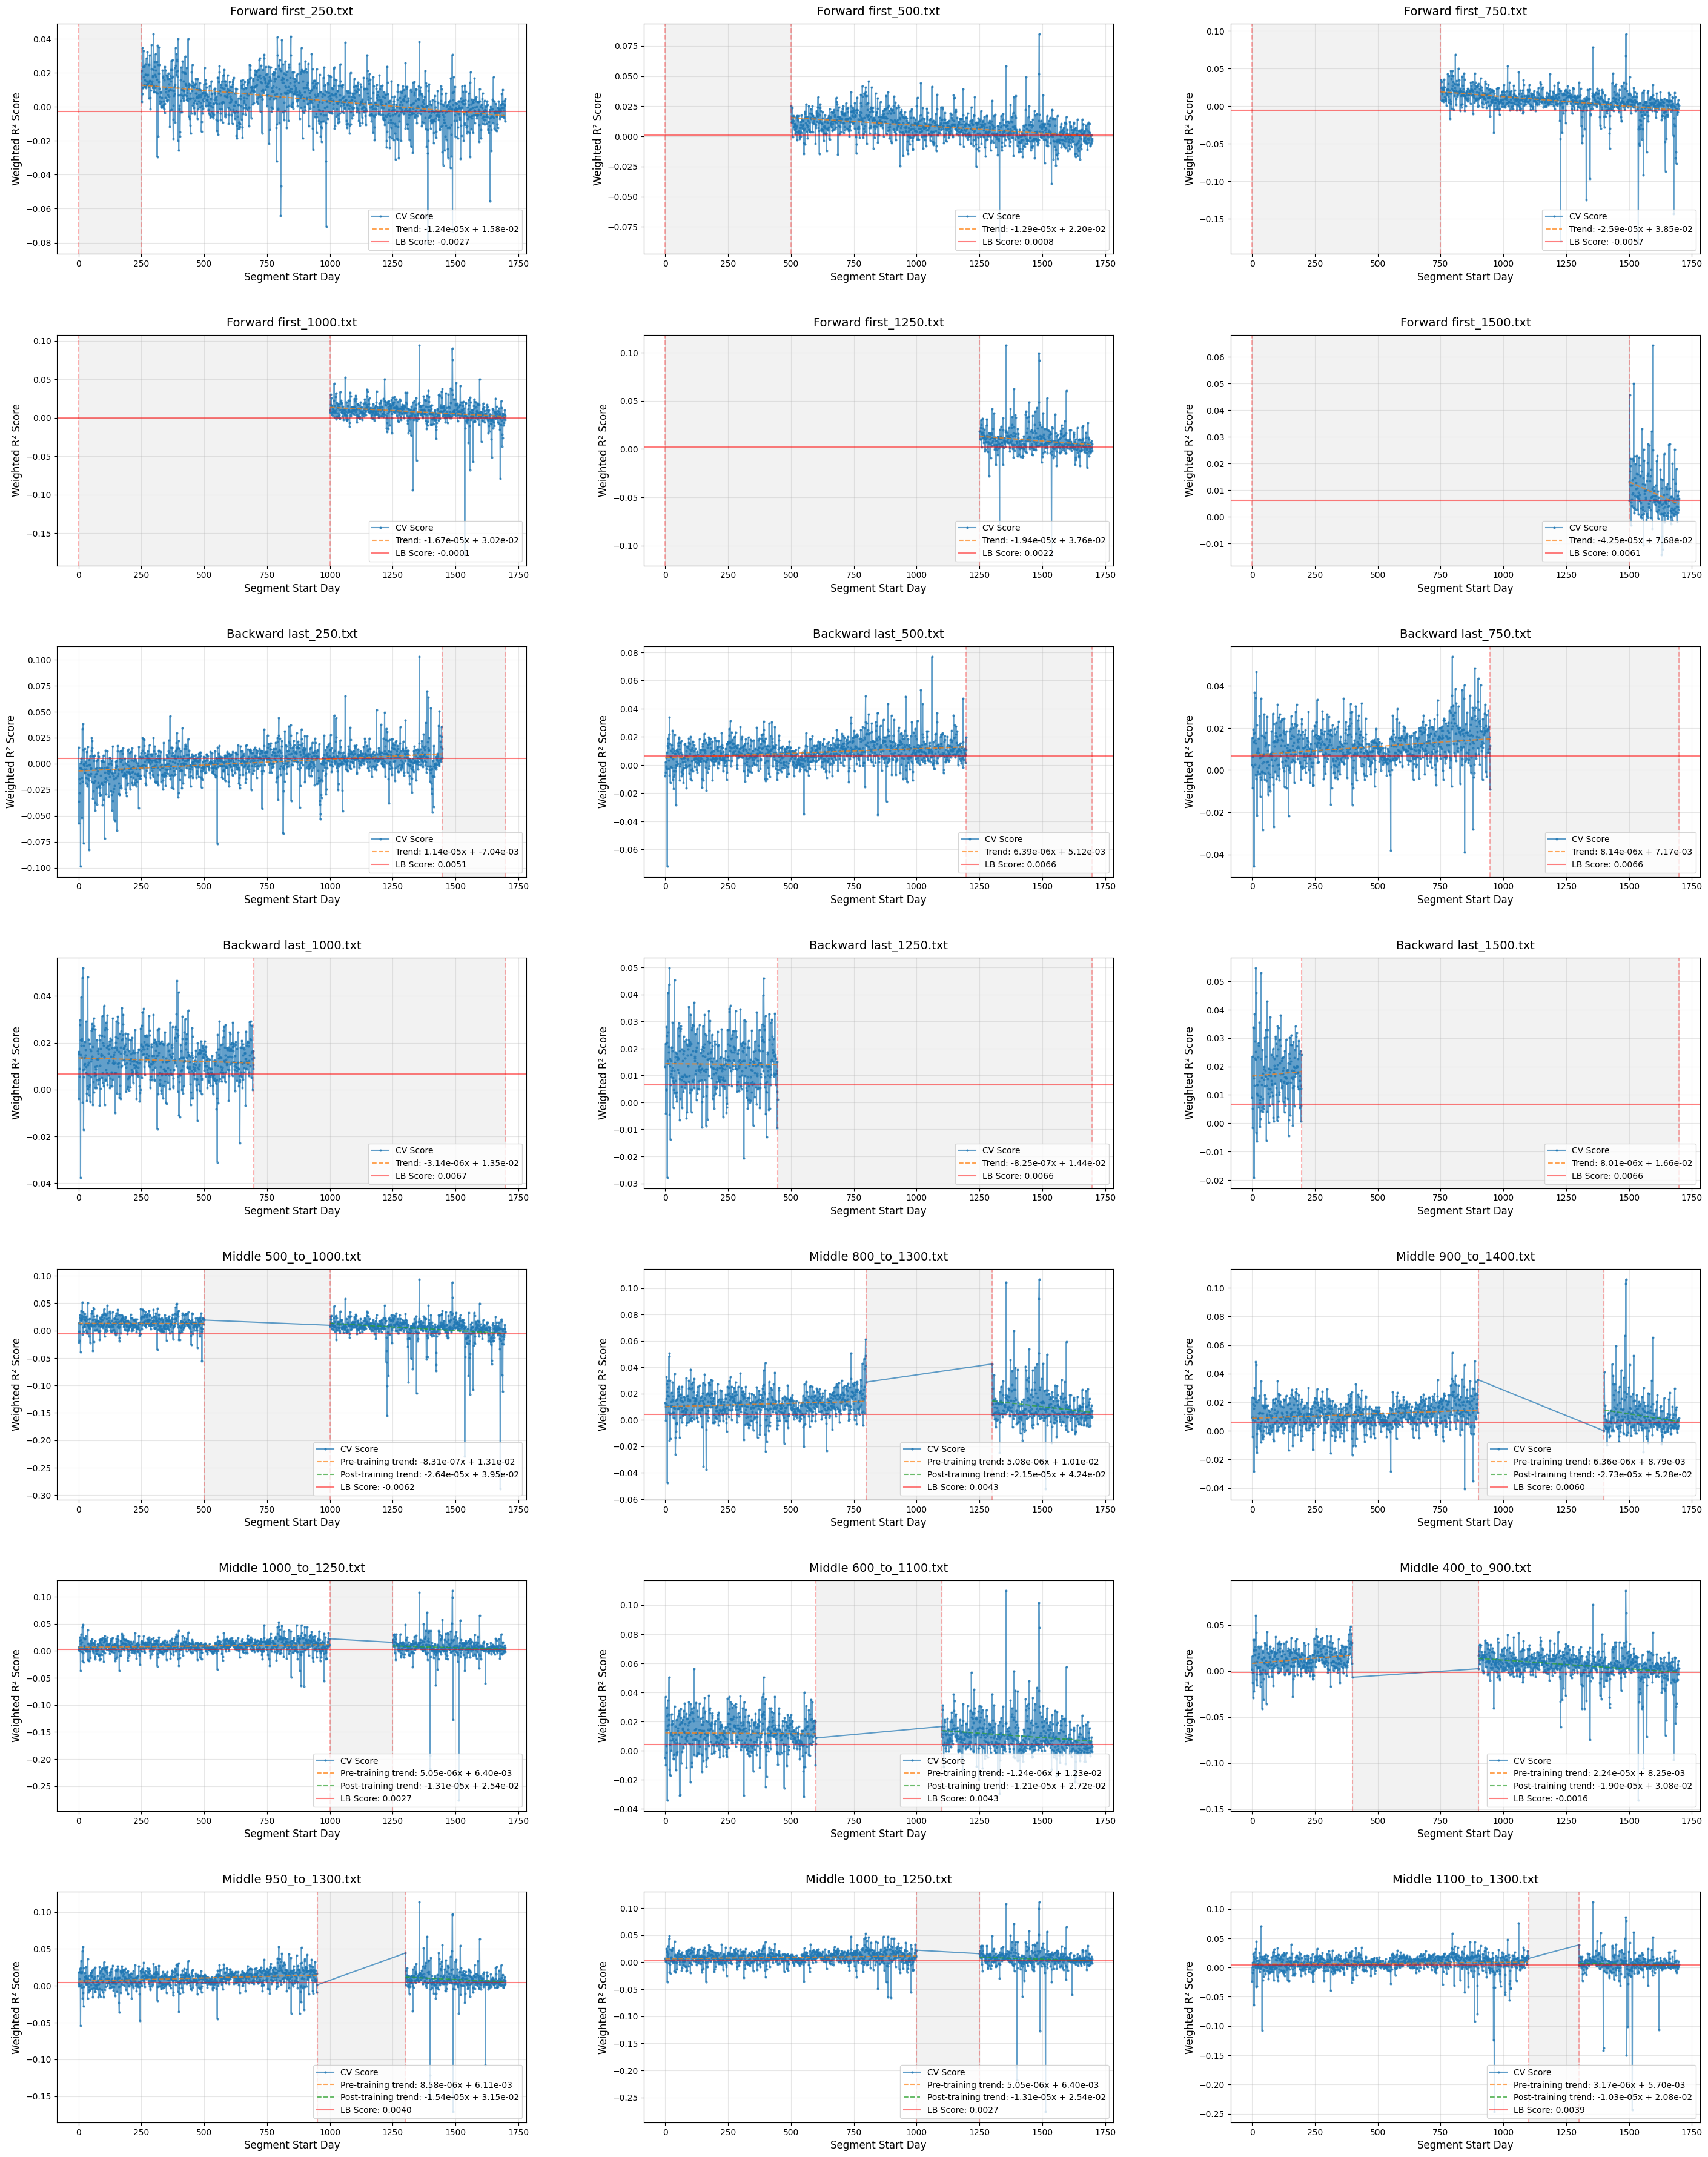

In [13]:
# Define LB scores
LB_SCORES = {
    'first_250.txt': -0.0027,
    'first_500.txt': 0.0008,
    'first_750.txt': -0.0057,
    'first_1000.txt': -0.0001,
    'first_1250.txt': 0.0022,
    'first_1500.txt': 0.0061,

    'last_250.txt': 0.0051,
    'last_500.txt': 0.0066,
    'last_750.txt': 0.0066,
    'last_1000.txt': 0.0067,
    'last_1250.txt': 0.0066,
    'last_1500.txt': 0.0066,

    '500_to_1000.txt': -0.0062,
    '800_to_1300.txt': 0.0043,
    '900_to_1400.txt': 0.0060,
    '400_to_900.txt': -0.0016,
    '600_to_1100.txt': 0.0043,
    '950_to_1300.txt': 0.0040,
    '1100_to_1300.txt': 0.0039,
    '1000_to_1250.txt': 0.0027
}

# Create subplot grid (6x3)
fig = plt.figure(figsize=(35, 45))  # Even bigger
gs = fig.add_gridspec(7, 3, hspace=0.35, wspace=0.25)  # Slightly more spacing
axes = gs.subplots(squeeze=True).flatten()

# For correlation analysis
cv_lb_comparison = {
    'model_name': [],
    'lb_score': [],
    'final_cv_score': []
}

# Plot each model in its own subplot
for idx, model_config in enumerate(MODELS):
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)
    lb_score = LB_SCORES[model_name]
    
    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        cv_lb_comparison['model_name'].append(model_name)
        cv_lb_comparison['lb_score'].append(lb_score)
        cv_lb_comparison['final_cv_score'].append(valid_results[r2_col].iloc[-1])
    
    # Plot scores
    axes[idx].plot(valid_results['start_day'], valid_results[r2_col], 
                  marker='o', markersize=2,
                  label='CV Score', alpha=0.7)
    
    # Add trend line(s)
    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]
            
            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(before_results['start_day'], p(before_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Pre-training trend: {z[0]:.2e}x + {z[1]:.2e}')
            
            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(after_results['start_day'], p(after_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Post-training trend: {z[0]:.2e}x + {z[1]:.2e}')
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            p = np.poly1d(z)
            axes[idx].plot(valid_results['start_day'], p(valid_results['start_day']), 
                      "--", alpha=0.7,
                      label=f'Trend: {z[0]:.2e}x + {z[1]:.2e}')
    
    # Add LB score line
    axes[idx].axhline(y=lb_score, color='r', linestyle='-', 
                     label=f'LB Score: {lb_score:.4f}', alpha=0.5)
    
    # Add vertical lines showing training period
    axes[idx].axvline(x=train_start, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvline(x=train_end, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvspan(train_start, train_end, color='gray', alpha=0.1)
    
    # Customize subplot
    model_type = "Forward" if is_forward else ("Backward" if is_backward else "Middle")
    axes[idx].set_title(f'{model_type} {model_name}', fontsize=14, pad=10)
    axes[idx].set_xlabel('Segment Start Day', fontsize=12)
    axes[idx].set_ylabel('Weighted R² Score', fontsize=12)
    axes[idx].tick_params(axis='both', labelsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='lower right', fontsize=10)  # Fixed legend position

# Remove extra subplots
for idx in range(len(MODELS), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

## It looks like there is a consistent drop-off between ALL models for their post-training data points. We can use this to weight our validation and better estimate true LB scores!

In [17]:
# Store pre and post trend lines separately
pre_trends = {}
post_trends = {}

total_training_days = []

for model_config in MODELS:
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    total_days = train_end - train_start
    total_training_days.append(total_days)

    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)

    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()

    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]

            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                pre_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': before_results['start_day'] - train_start
                }

            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                post_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': after_results['start_day'] - train_end
                }
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            if is_forward:
                post_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_end
                }
            else:  # backward
                pre_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_start
                }

# Print pre-training trend lines
print("\nPre-training trend lines (predictions before training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15}       {'Total Days':<10}")
print("-" * 80)

sorted_pre = sorted(pre_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_pre:
    total_days = next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model_name)
    print(f"{model_name:<20} {trend['slope']:.2e}        {trend['intercept']:.2e}       {total_days:<10}")

pre_slopes = [trend['slope'] for trend in pre_trends.values()]
print(f"\nPre-training average slope: {np.mean(pre_slopes):.2e}")
print(f"Pre-training slope std dev: {np.std(pre_slopes):.2e}")

# Print post-training trend lines
print("\nPost-training trend lines (predictions after training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15}        {'Total Days':<10}")
print("-" * 80)

sorted_post = sorted(post_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_post:
    total_days = next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model_name)
    print(f"{model_name:<20} {trend['slope']:.2e}        {trend['intercept']:.2e}        {total_days:<10}")

post_slopes = [trend['slope'] for trend in post_trends.values()]
print(f"\nPost-training average slope: {np.mean(post_slopes):.2e}")
print(f"Post-training slope std dev: {np.std(post_slopes):.2e}")



Pre-training trend lines (predictions before training period):
--------------------------------------------------------------------------------
Model                Slope           Intercept             Total Days
--------------------------------------------------------------------------------
400_to_900.txt       2.24e-05        8.25e-03       500       
last_250.txt         1.14e-05        -7.04e-03       250       
950_to_1300.txt      8.58e-06        6.11e-03       350       
last_750.txt         8.14e-06        7.17e-03       750       
last_1500.txt        8.01e-06        1.66e-02       1500      
last_500.txt         6.39e-06        5.12e-03       500       
900_to_1400.txt      6.36e-06        8.79e-03       500       
800_to_1300.txt      5.08e-06        1.01e-02       500       
1000_to_1250.txt     5.05e-06        6.40e-03       250       
1100_to_1300.txt     3.17e-06        5.70e-03       200       
last_1000.txt        -3.14e-06        1.35e-02       1000      
600_to_11

### It would be cool if this pattern also went backwards (It would allow me to do more quirky CV stuff), it almost looked like it could have, but I would need more data to confirm. But also, if it is random, it means I can ignore it? Do more tests.

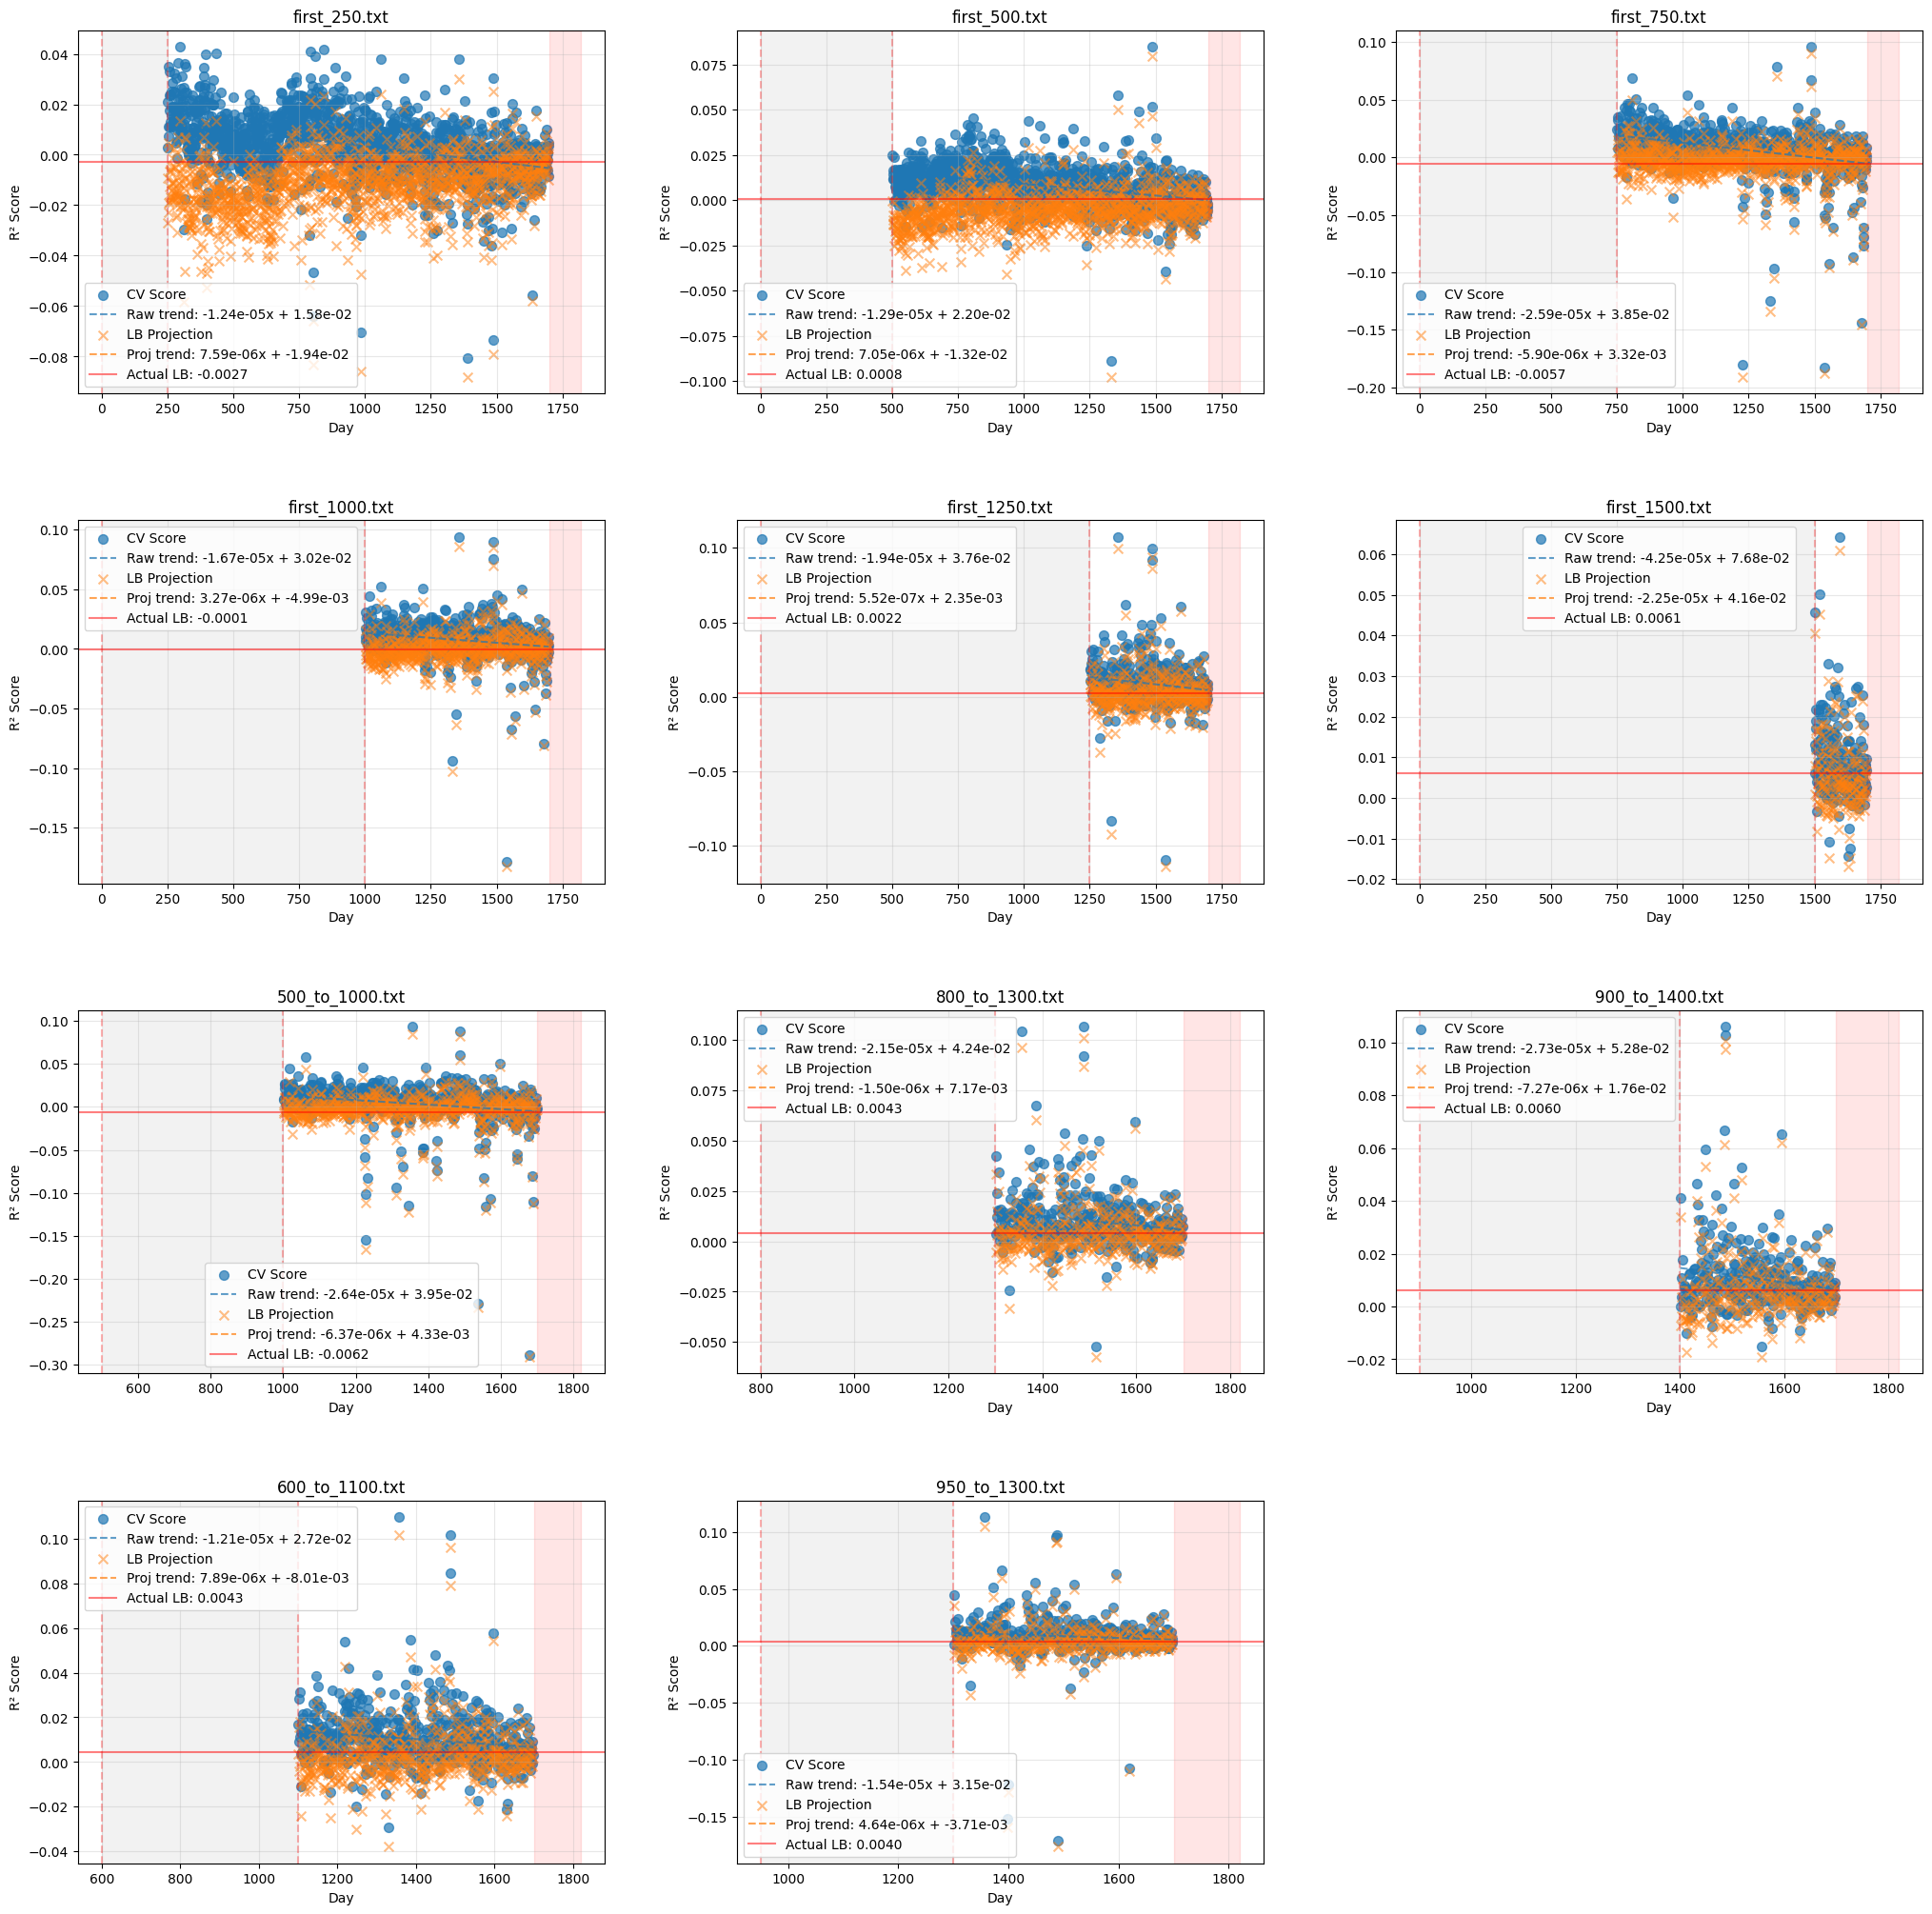


Trend Line Slopes Comparison:
--------------------------------------------------------------------------------
Model           Raw Slope       Projected Slope     Slope Reduction %   
--------------------------------------------------------------------------------
first_250.txt   -1.24e-05        7.59e-06            38.9               
first_500.txt   -1.29e-05        7.05e-06            45.5               
first_750.txt   -2.59e-05       -5.90e-06            77.2               
first_1000.txt  -1.67e-05        3.27e-06            80.4               
first_1250.txt  -1.94e-05        5.52e-07            97.2               
first_1500.txt  -4.25e-05       -2.25e-05            47.1               
500_to_1000.txt -2.64e-05       -6.37e-06            75.8               
800_to_1300.txt -2.15e-05       -1.50e-06            93.0               
900_to_1400.txt -2.73e-05       -7.27e-06            73.3               
600_to_1100.txt -1.21e-05        7.89e-06            34.8               
950_

In [ ]:
# Parameters
DECAY_RATE = -2e-05  # observed post-training decay rate
LB_START = 1700
LB_END = 1820

def calculate_lb_projection(score, val_day):
    """Calculate average projected performance over LB period"""
    days_to_lb_start = LB_START - val_day
    days_to_lb_end = LB_END - val_day
    return score + (DECAY_RATE * ((days_to_lb_start + days_to_lb_end) / 2))

# Get forward-predicting models only
forward_models = [m for m in MODELS if m['name'].startswith(('first_', '300_to_', '400_to_', '500_to_', '600_to_', '800_to_', '900_to_', '950_to_', '1000_to_', '1100_to_'))]

# Create subplot grid (3x3)
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.25)
axes = gs.subplots(squeeze=True).flatten()

# Plot each model in its own subplot
for idx, model_config in enumerate(forward_models):
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get post-training validation results only
    valid_results = results_df[
        results_df['start_day'] > train_end
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        days = valid_results['start_day'].values
        scores = valid_results[r2_col].values
        projections = [calculate_lb_projection(score, day) for score, day in zip(scores, days)]
        
        # Plot raw scores and their trend
        axes[idx].scatter(days, scores, alpha=0.7, label='CV Score', s=50)
        z_raw = np.polyfit(days, scores, 1)
        p_raw = np.poly1d(z_raw)
        axes[idx].plot(days, p_raw(days), '--', alpha=0.7, 
                      label=f'Raw trend: {z_raw[0]:.2e}x + {z_raw[1]:.2e}')
        
        # Plot projections and their trend
        axes[idx].scatter(days, projections, alpha=0.5, marker='x', s=50, 
                         label='LB Projection')
        z_proj = np.polyfit(days, projections, 1)
        p_proj = np.poly1d(z_proj)
        axes[idx].plot(days, p_proj(days), '--', alpha=0.7,
                      label=f'Proj trend: {z_proj[0]:.2e}x + {z_proj[1]:.2e}')
        
        # Add actual LB score line
        if model_name in LB_SCORES:
            axes[idx].axhline(y=LB_SCORES[model_name], color='r', linestyle='-', 
                            label=f'Actual LB: {LB_SCORES[model_name]:.4f}', alpha=0.5)
        
        # Add training period shading
        axes[idx].axvspan(train_start, train_end, color='gray', alpha=0.1)
        axes[idx].axvline(x=train_start, color='r', linestyle='--', alpha=0.3)
        axes[idx].axvline(x=train_end, color='r', linestyle='--', alpha=0.3)
        
        # Add LB period shading
        axes[idx].axvspan(LB_START, LB_END, color='red', alpha=0.1)
        
        # Customize subplot
        axes[idx].set_title(f'{model_name}', fontsize=12)
        axes[idx].set_xlabel('Day', fontsize=10)
        axes[idx].set_ylabel('R² Score', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(loc='best')

# Remove extra subplots
for idx in range(len(forward_models), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

# Print trend line slopes for comparison
print("\nTrend Line Slopes Comparison:")
print("-" * 80)
print(f"{'Model':<15} {'Raw Slope':<15} {'Projected Slope':<15}     {'Slope Reduction %':<20}")
print("-" * 80)

for model_config in forward_models:
    model_name = model_config['name']
    r2_col = f'r2_score_{model_name}'
    
    valid_results = results_df[
        results_df['start_day'] > model_config['train_end']
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        days = valid_results['start_day'].values
        scores = valid_results[r2_col].values
        projections = [calculate_lb_projection(score, day) for score, day in zip(scores, days)]
        
        raw_slope = np.polyfit(days, scores, 1)[0]
        proj_slope = np.polyfit(days, projections, 1)[0]
        
        reduction = (1 - abs(proj_slope)/abs(raw_slope)) * 100 if raw_slope != 0 else 0
        
        print(f"{model_name:<15} {raw_slope:< 15.2e} {proj_slope:< 15.2e}     {reduction:< 20.1f}")

## Correlated scores val-LB from decay adjusted days

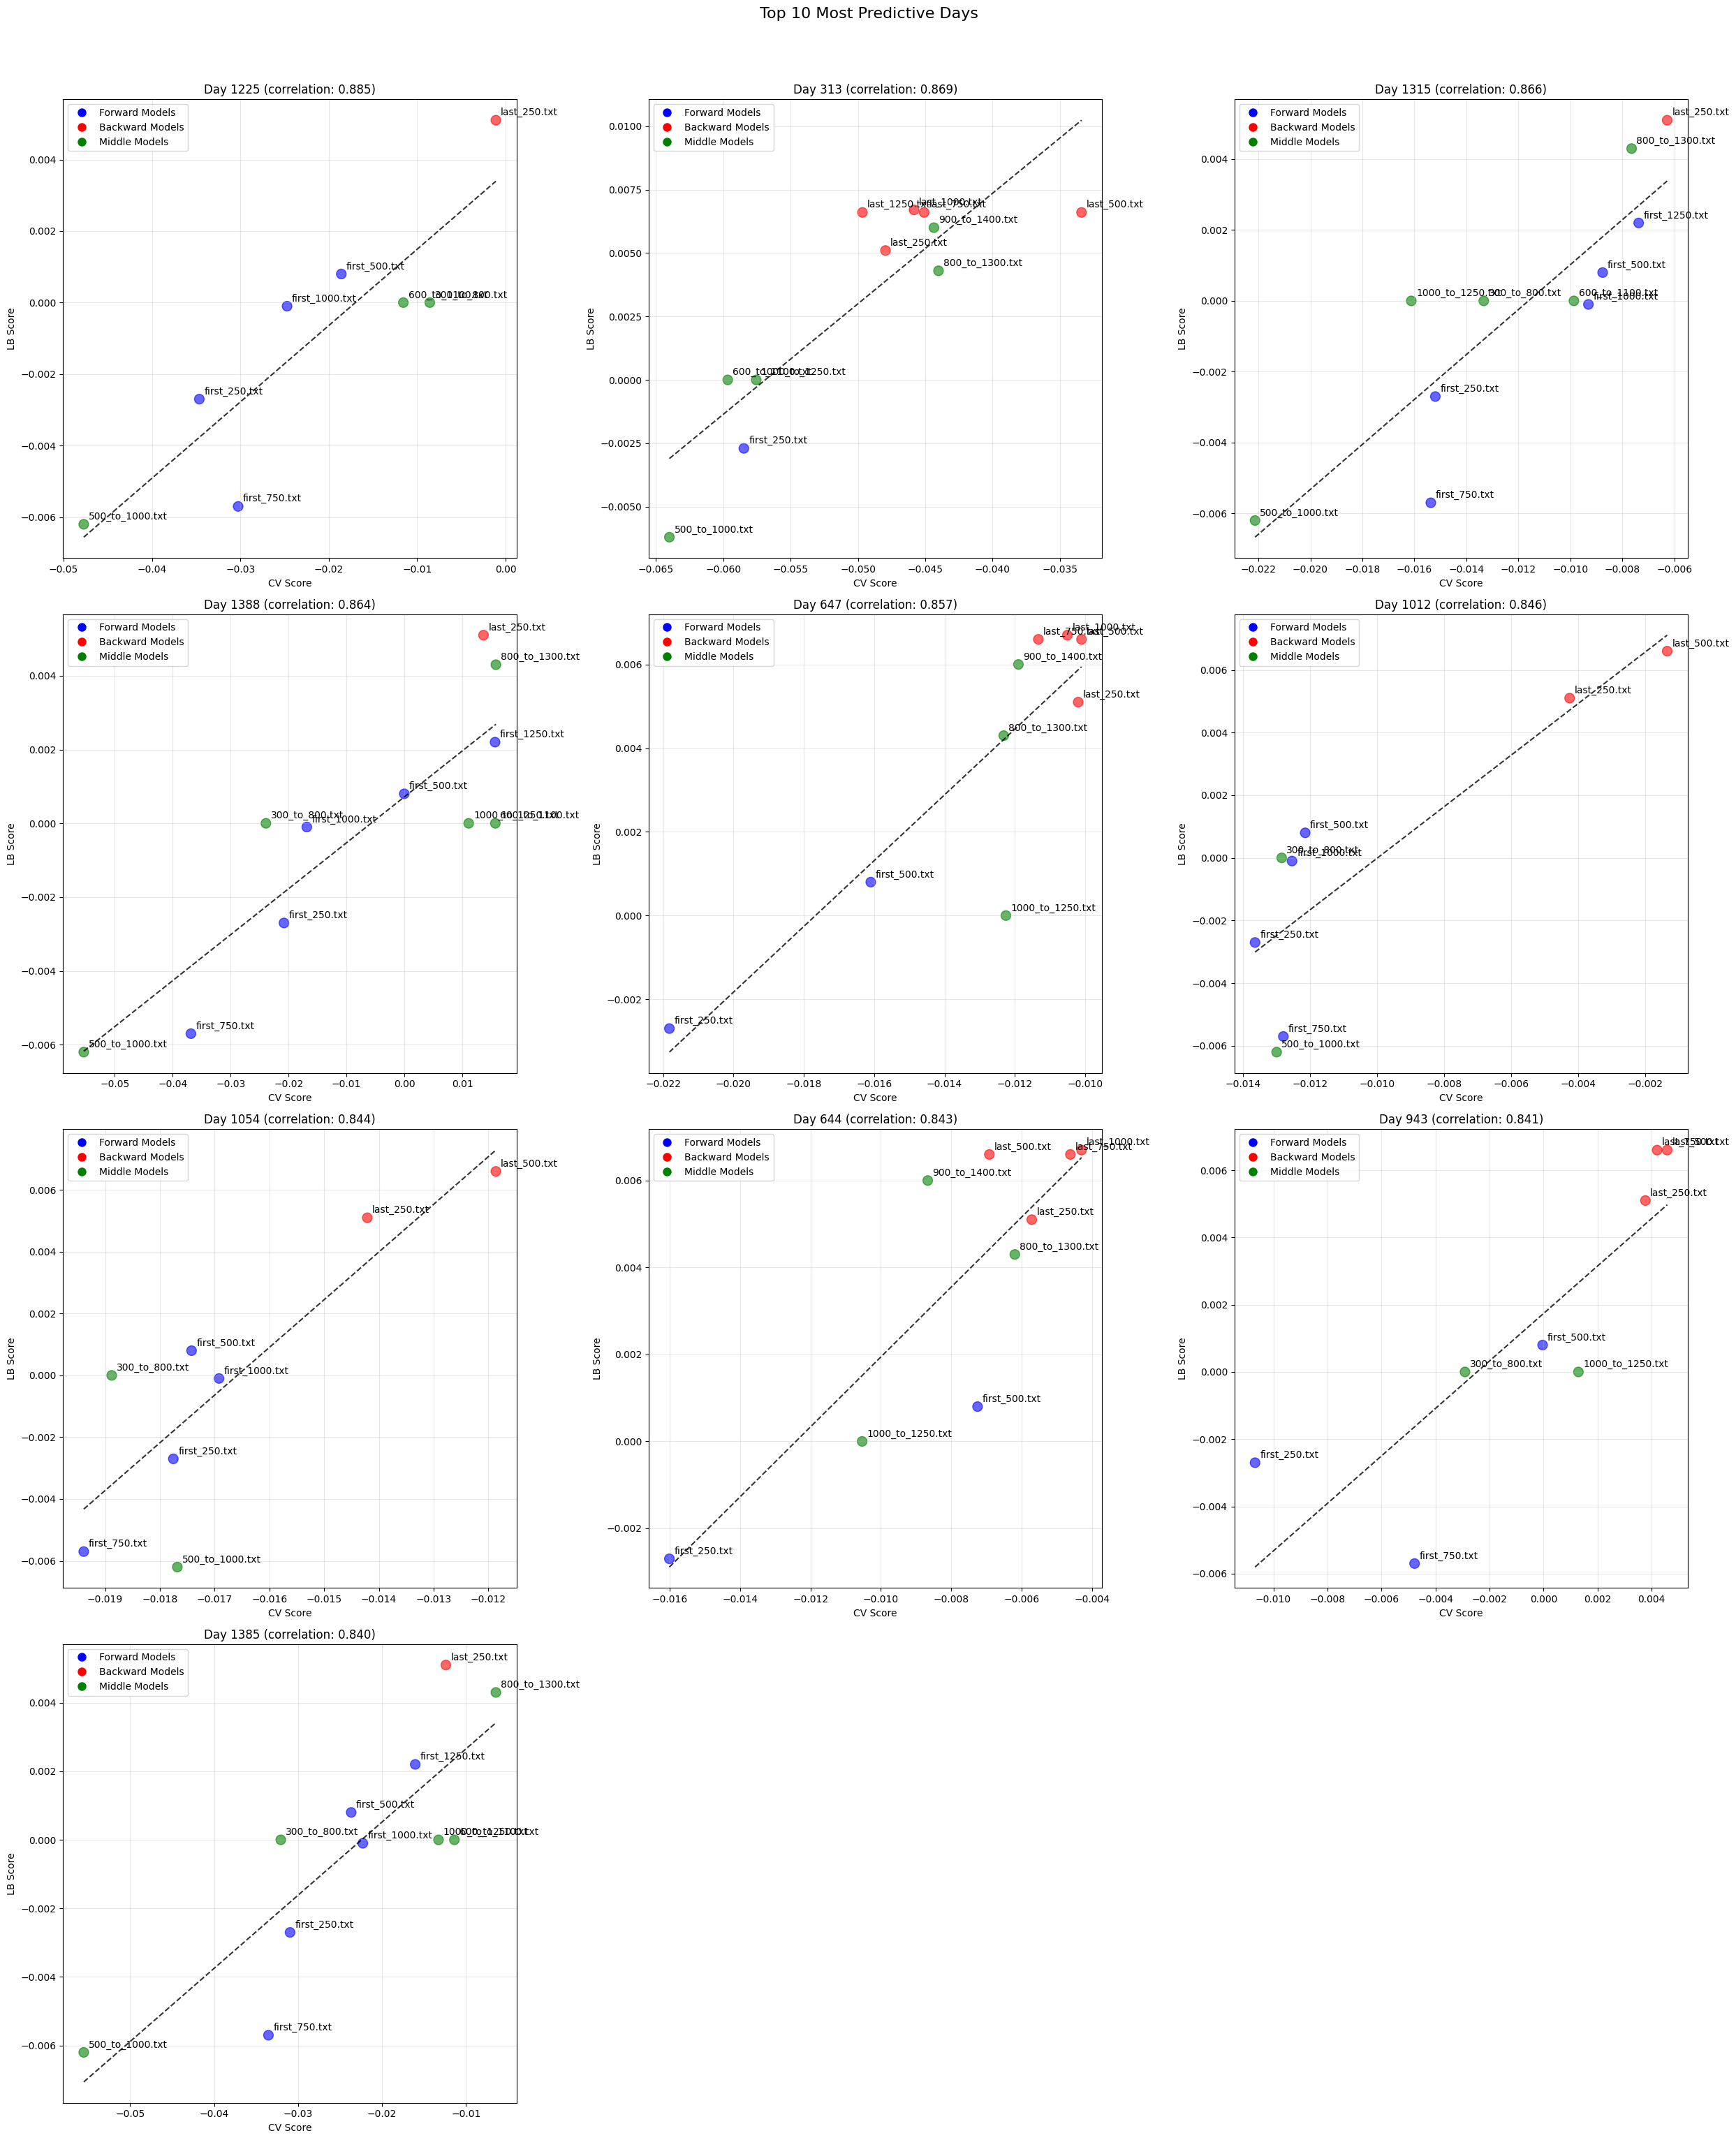

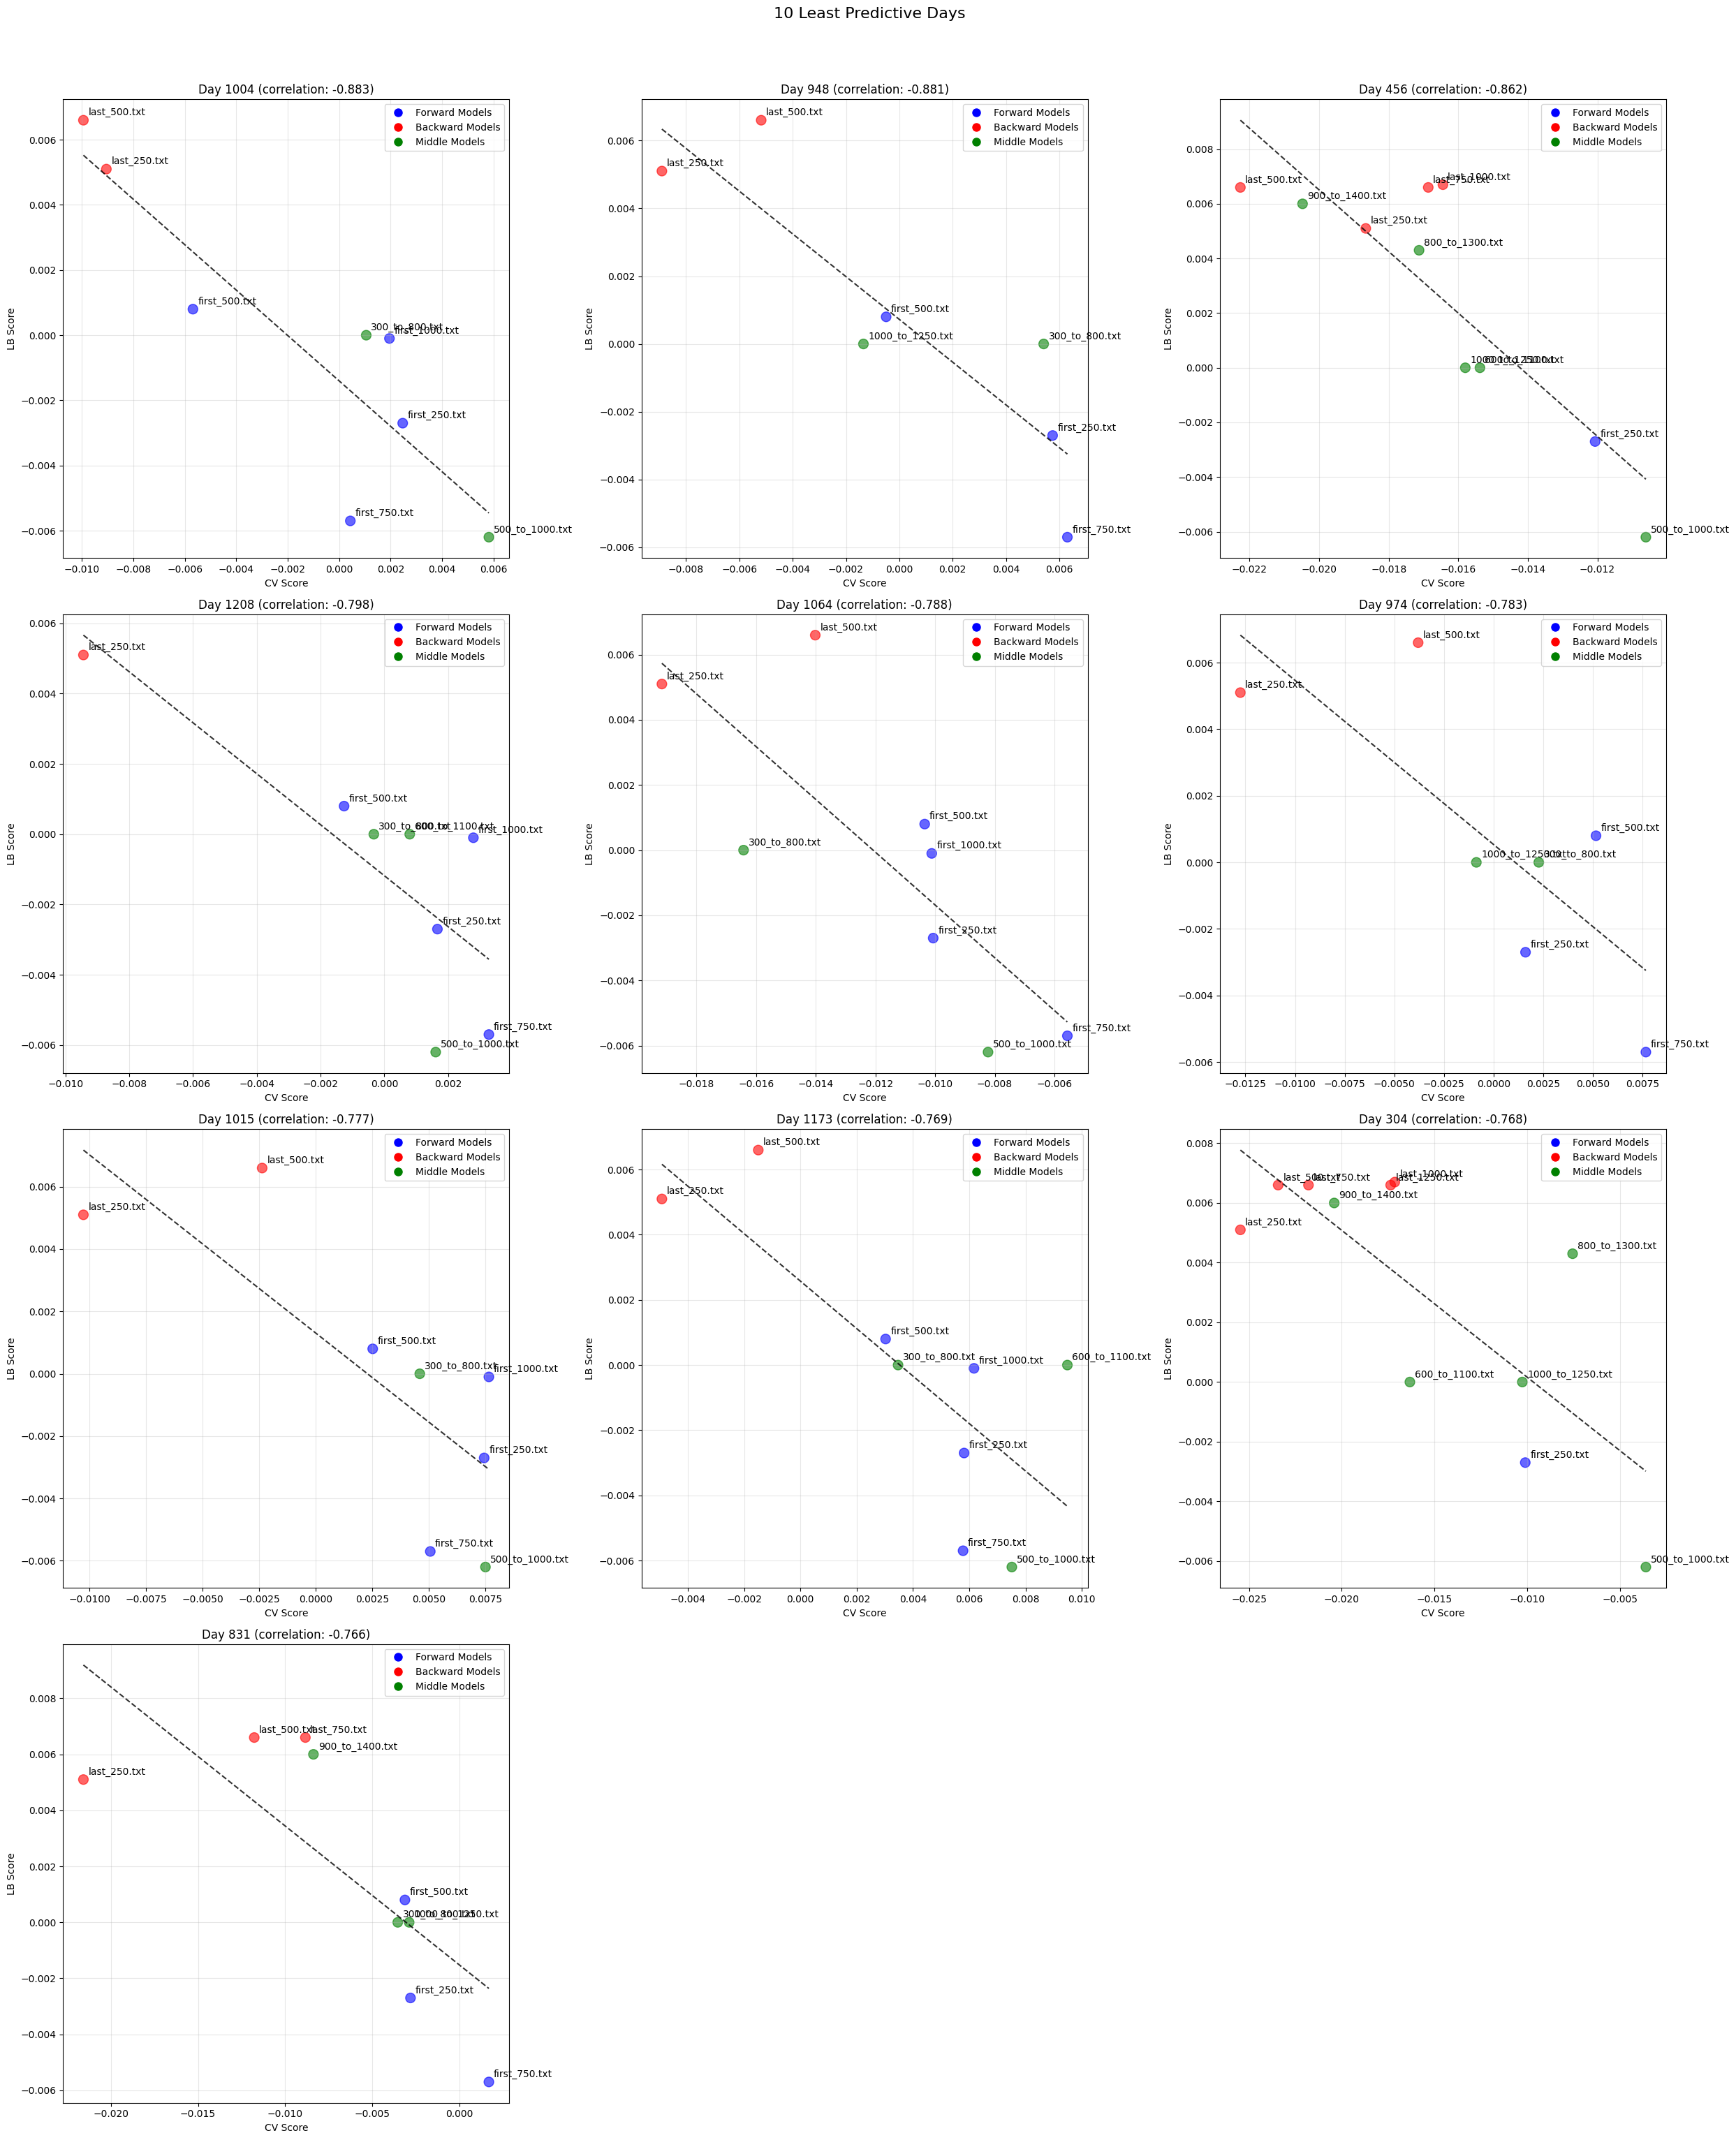


Total qualifying days: 1197
Average correlation: 0.004
Correlation std dev: 0.395

Top 10 most predictive days:
--------------------------------------------------------------------------------

Day 1225 (correlation: 0.885):
         300_to_800.txt  CV: -0.0086    LB:  0.0000   
         500_to_1000.txt CV: -0.0477    LB: -0.0062   
         600_to_1100.txt CV: -0.0116    LB:  0.0000   
         first_1000.txt  CV: -0.0247    LB: -0.0001   
         first_250.txt   CV: -0.0346    LB: -0.0027   
         first_500.txt   CV: -0.0186    LB:  0.0008   
         first_750.txt   CV: -0.0303    LB: -0.0057   
         last_250.txt    CV: -0.0011    LB:  0.0051   

Day 313 (correlation: 0.869):
         1000_to_1250.txt CV: -0.0576    LB:  0.0000   
         500_to_1000.txt CV: -0.0640    LB: -0.0062   
         600_to_1100.txt CV: -0.0597    LB:  0.0000   
         800_to_1300.txt CV: -0.0440    LB:  0.0043   
         900_to_1400.txt CV: -0.0444    LB:  0.0060   
         first_250.txt   CV

: 

In [ ]:
# Calculate correlation for each day using decay-adjusted scores
day_correlations = {}
day_predictions = {}

for day in sorted(results_df['start_day'].unique()):
    day_scores = []
    lb_scores = []
    model_predictions = {}
    model_types = set()
    
    for model_config in MODELS:
        model_name = model_config['name']
        train_start = model_config['train_start']
        train_end = model_config['train_end']
        r2_col = f'r2_score_{model_name}'
        
        # Check if this day is valid (outside training period)
        if day < train_start or day > train_end:
            # Get score for this day
            day_score = results_df[results_df['start_day'] == day][r2_col].iloc[0] \
                if len(results_df[results_df['start_day'] == day]) > 0 else None
            
            if day_score is not None:
                # Calculate decay adjustment based on distance from training
                if day > train_end:  # Forward prediction
                    distance = day - train_end
                    adjusted_score = calculate_lb_projection(day_score, day)
                else:  # Backward prediction
                    distance = train_start - day
                    adjusted_score = calculate_lb_projection(day_score, day)
                
                day_scores.append(adjusted_score)
                lb_scores.append(LB_SCORES[model_name])
                model_predictions[model_name] = (adjusted_score, LB_SCORES[model_name])
                
                if model_name.startswith('first'):
                    model_types.add('forward')
                elif model_name.startswith('last'):
                    model_types.add('backward')
                else:
                    model_types.add('middle')
    
    # Calculate correlation if we have enough diverse models (at least 2 types)
    if len(model_types) >= 3:
        correlation = np.corrcoef(day_scores, lb_scores)[0,1]
        day_correlations[day] = correlation
        day_predictions[day] = model_predictions

# Get best and worst days by correlation
top_days = sorted(day_correlations.items(), key=lambda x: x[1], reverse=True)[:10]
bottom_days = sorted(day_correlations.items(), key=lambda x: x[1])[:10]

# Function to create scatter plot for a day
def plot_day_correlation(ax, day, correlation, predictions, title_prefix="Day"):
    day_scores = []
    lb_scores = []
    labels = []
    colors = []
    
    # Sort and prepare data
    sorted_predictions = sorted(predictions.items())
    for model_name, (day_score, lb_score) in sorted_predictions:
        day_scores.append(day_score)
        lb_scores.append(lb_score)
        labels.append(model_name)
        if model_name.startswith('first'):
            colors.append('blue')
        elif model_name.startswith('last'):
            colors.append('red')
        else:
            colors.append('green')
    
    # Create scatter plot
    scatter = ax.scatter(day_scores, lb_scores, c=colors, alpha=0.6, s=100)
    
    # Add trend line
    z = np.polyfit(day_scores, lb_scores, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(day_scores), max(day_scores), 100)
    ax.plot(x_range, p(x_range), "--", color='black', alpha=0.8, 
            label=f'Trend: y = {z[0]:.4f}x + {z[1]:.4f}')
    
    # Add labels
    for i, label in enumerate(labels):
        ax.annotate(label, (day_scores[i], lb_scores[i]), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10)
    
    # Customize plot
    ax.set_title(f'{title_prefix} {day} (correlation: {correlation:.3f})', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('CV Score', fontsize=10)
    ax.set_ylabel('LB Score', fontsize=10)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  label='Forward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  label='Backward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  label='Middle Models', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)

# Create subplot figures
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('Top 10 Most Predictive Days', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (day, correlation) in enumerate(top_days):
    plot_day_correlation(axes[idx], day, correlation, day_predictions[day])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Create subplot figure for worst days
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('10 Least Predictive Days', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (day, correlation) in enumerate(bottom_days):
    plot_day_correlation(axes[idx], day, correlation, day_predictions[day])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print details
print(f"\nTotal qualifying days: {len(day_correlations)}")
print(f"Average correlation: {np.mean(list(day_correlations.values())):.3f}")
print(f"Correlation std dev: {np.std(list(day_correlations.values())):.3f}")

# Print top and bottom days
for title, days in [("Top 10 most predictive days:", top_days), 
                   ("Bottom 10 least predictive days:", bottom_days)]:
    print(f"\n{title}")
    print("-" * 80)
    for day, correlation in days:
        print(f"\nDay {day} (correlation: {correlation:.3f}):")
        predictions = day_predictions[day]
        for model_name, (day_score, lb_score) in sorted(predictions.items()):
            print(f"{'':<8} {model_name:<15} CV: {day_score:< 10.4f} LB: {lb_score:< 10.4f}")

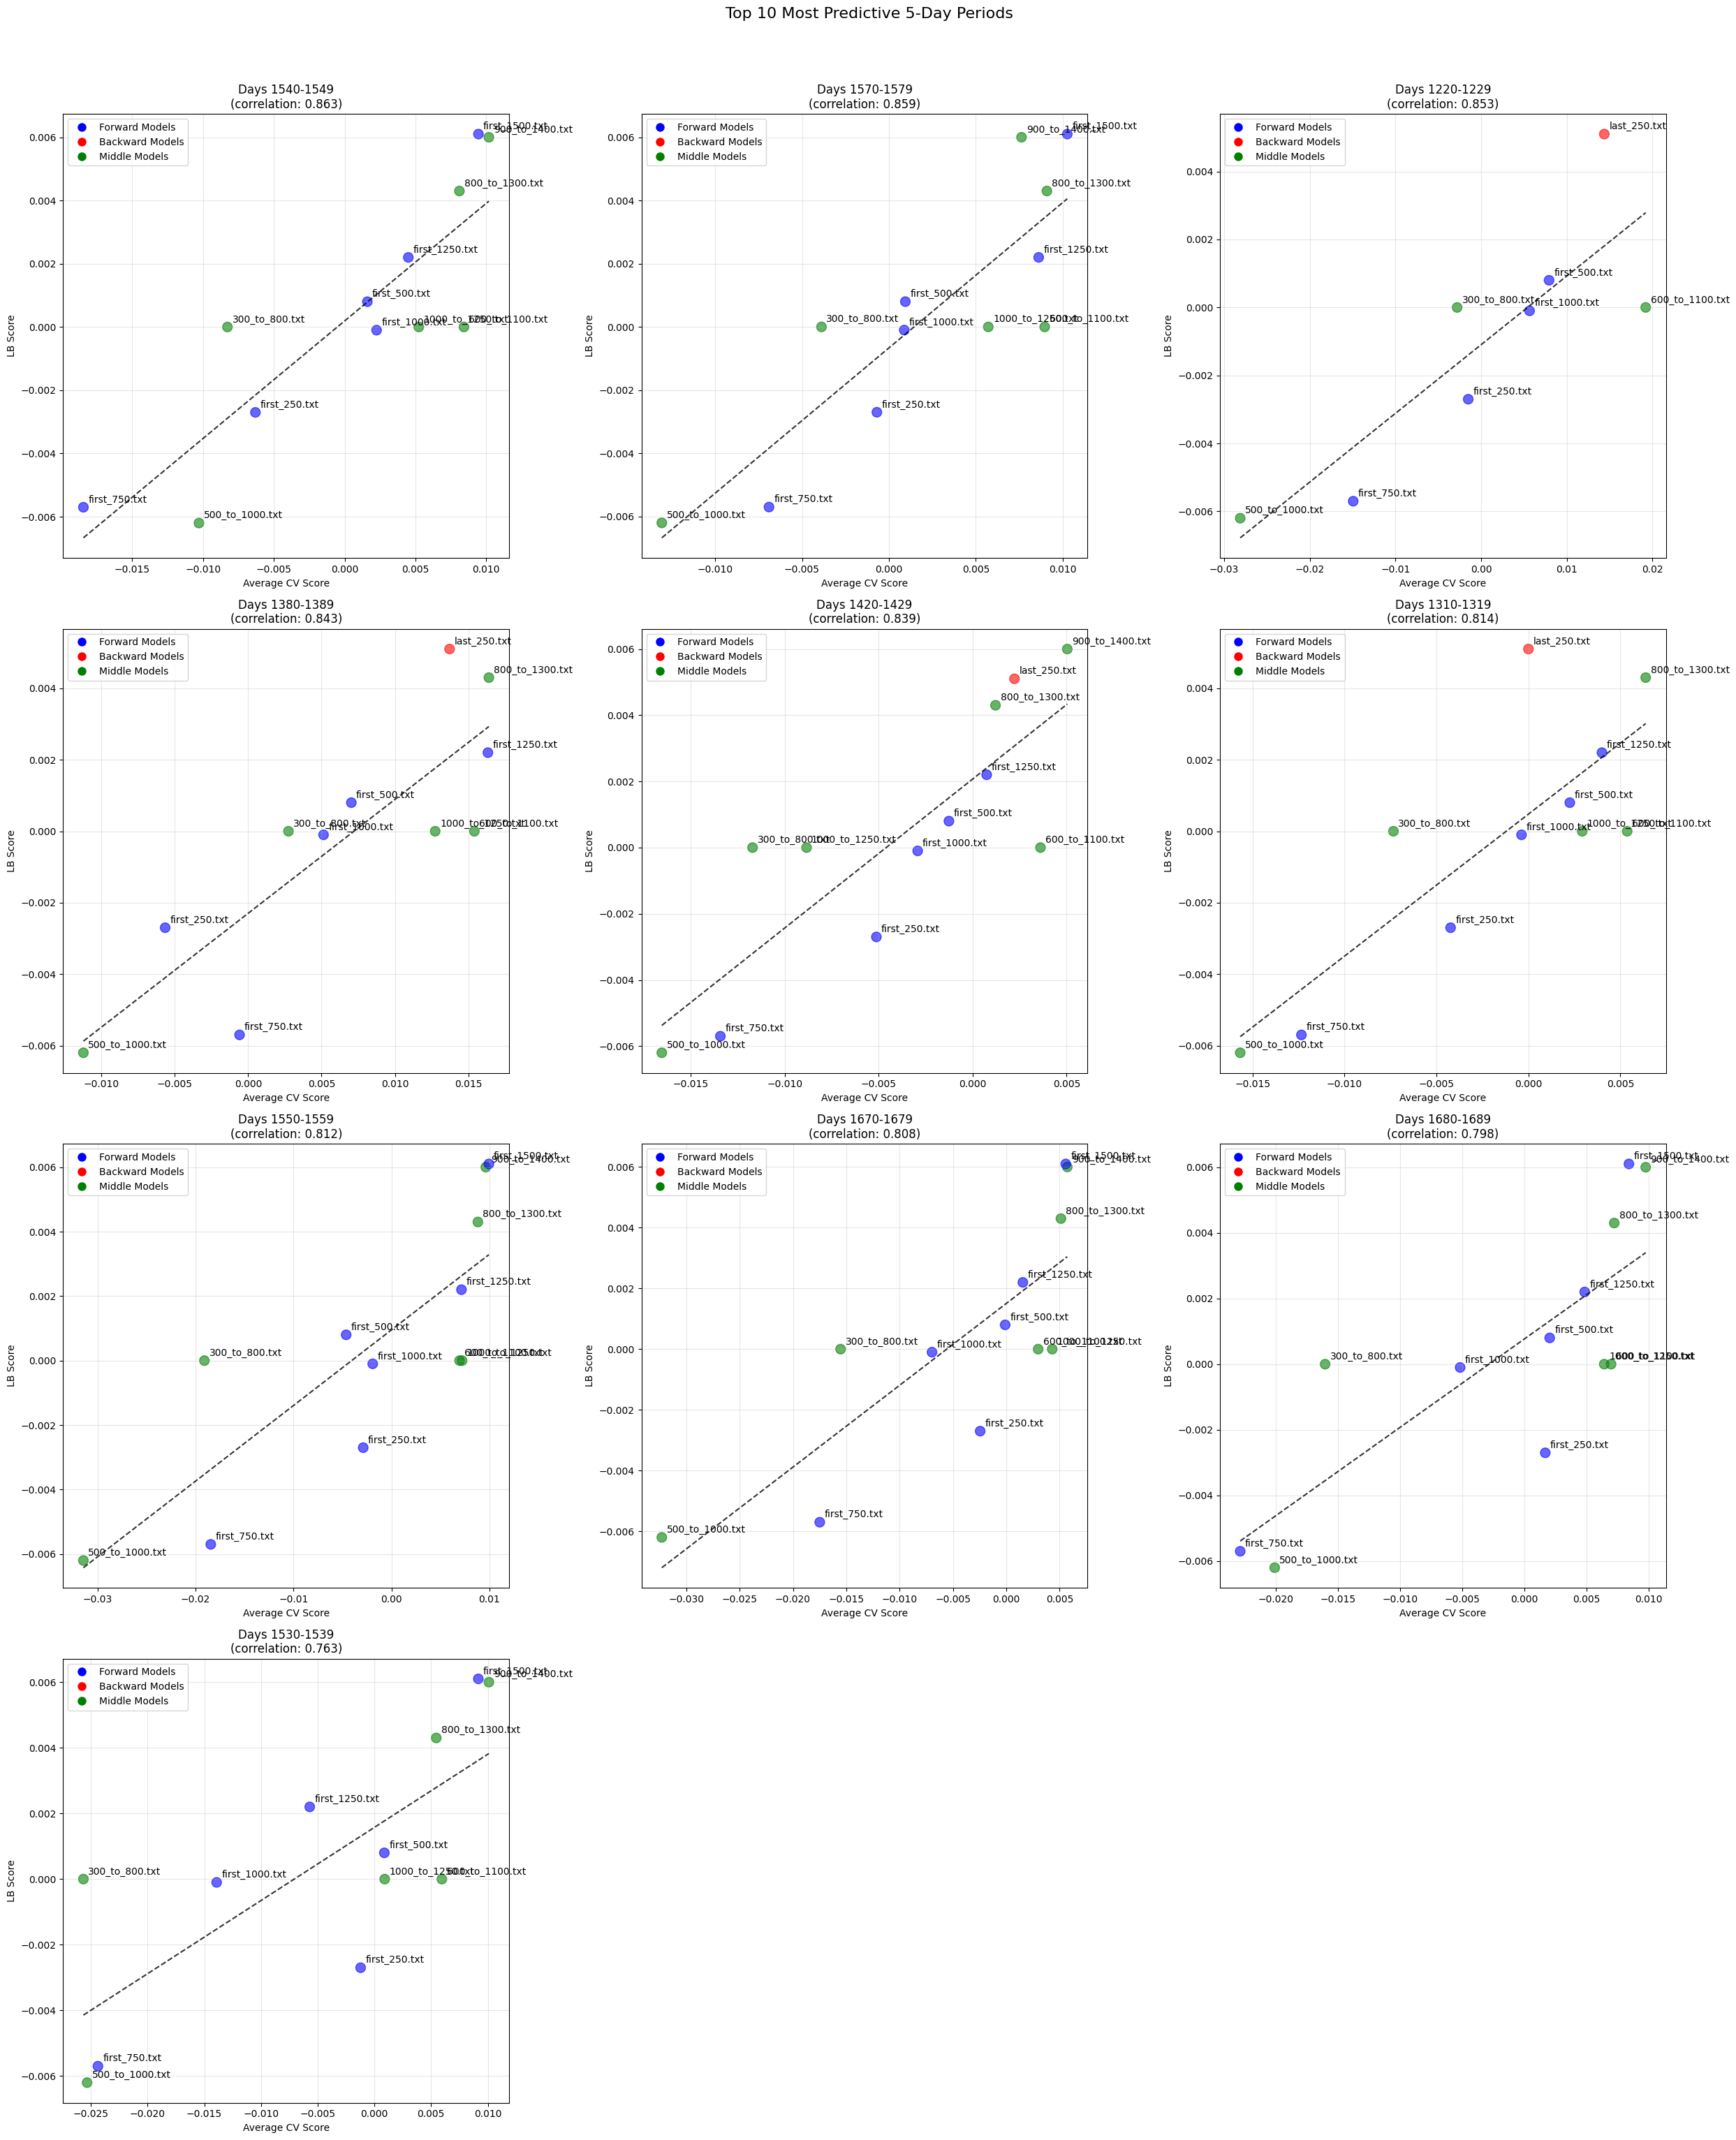

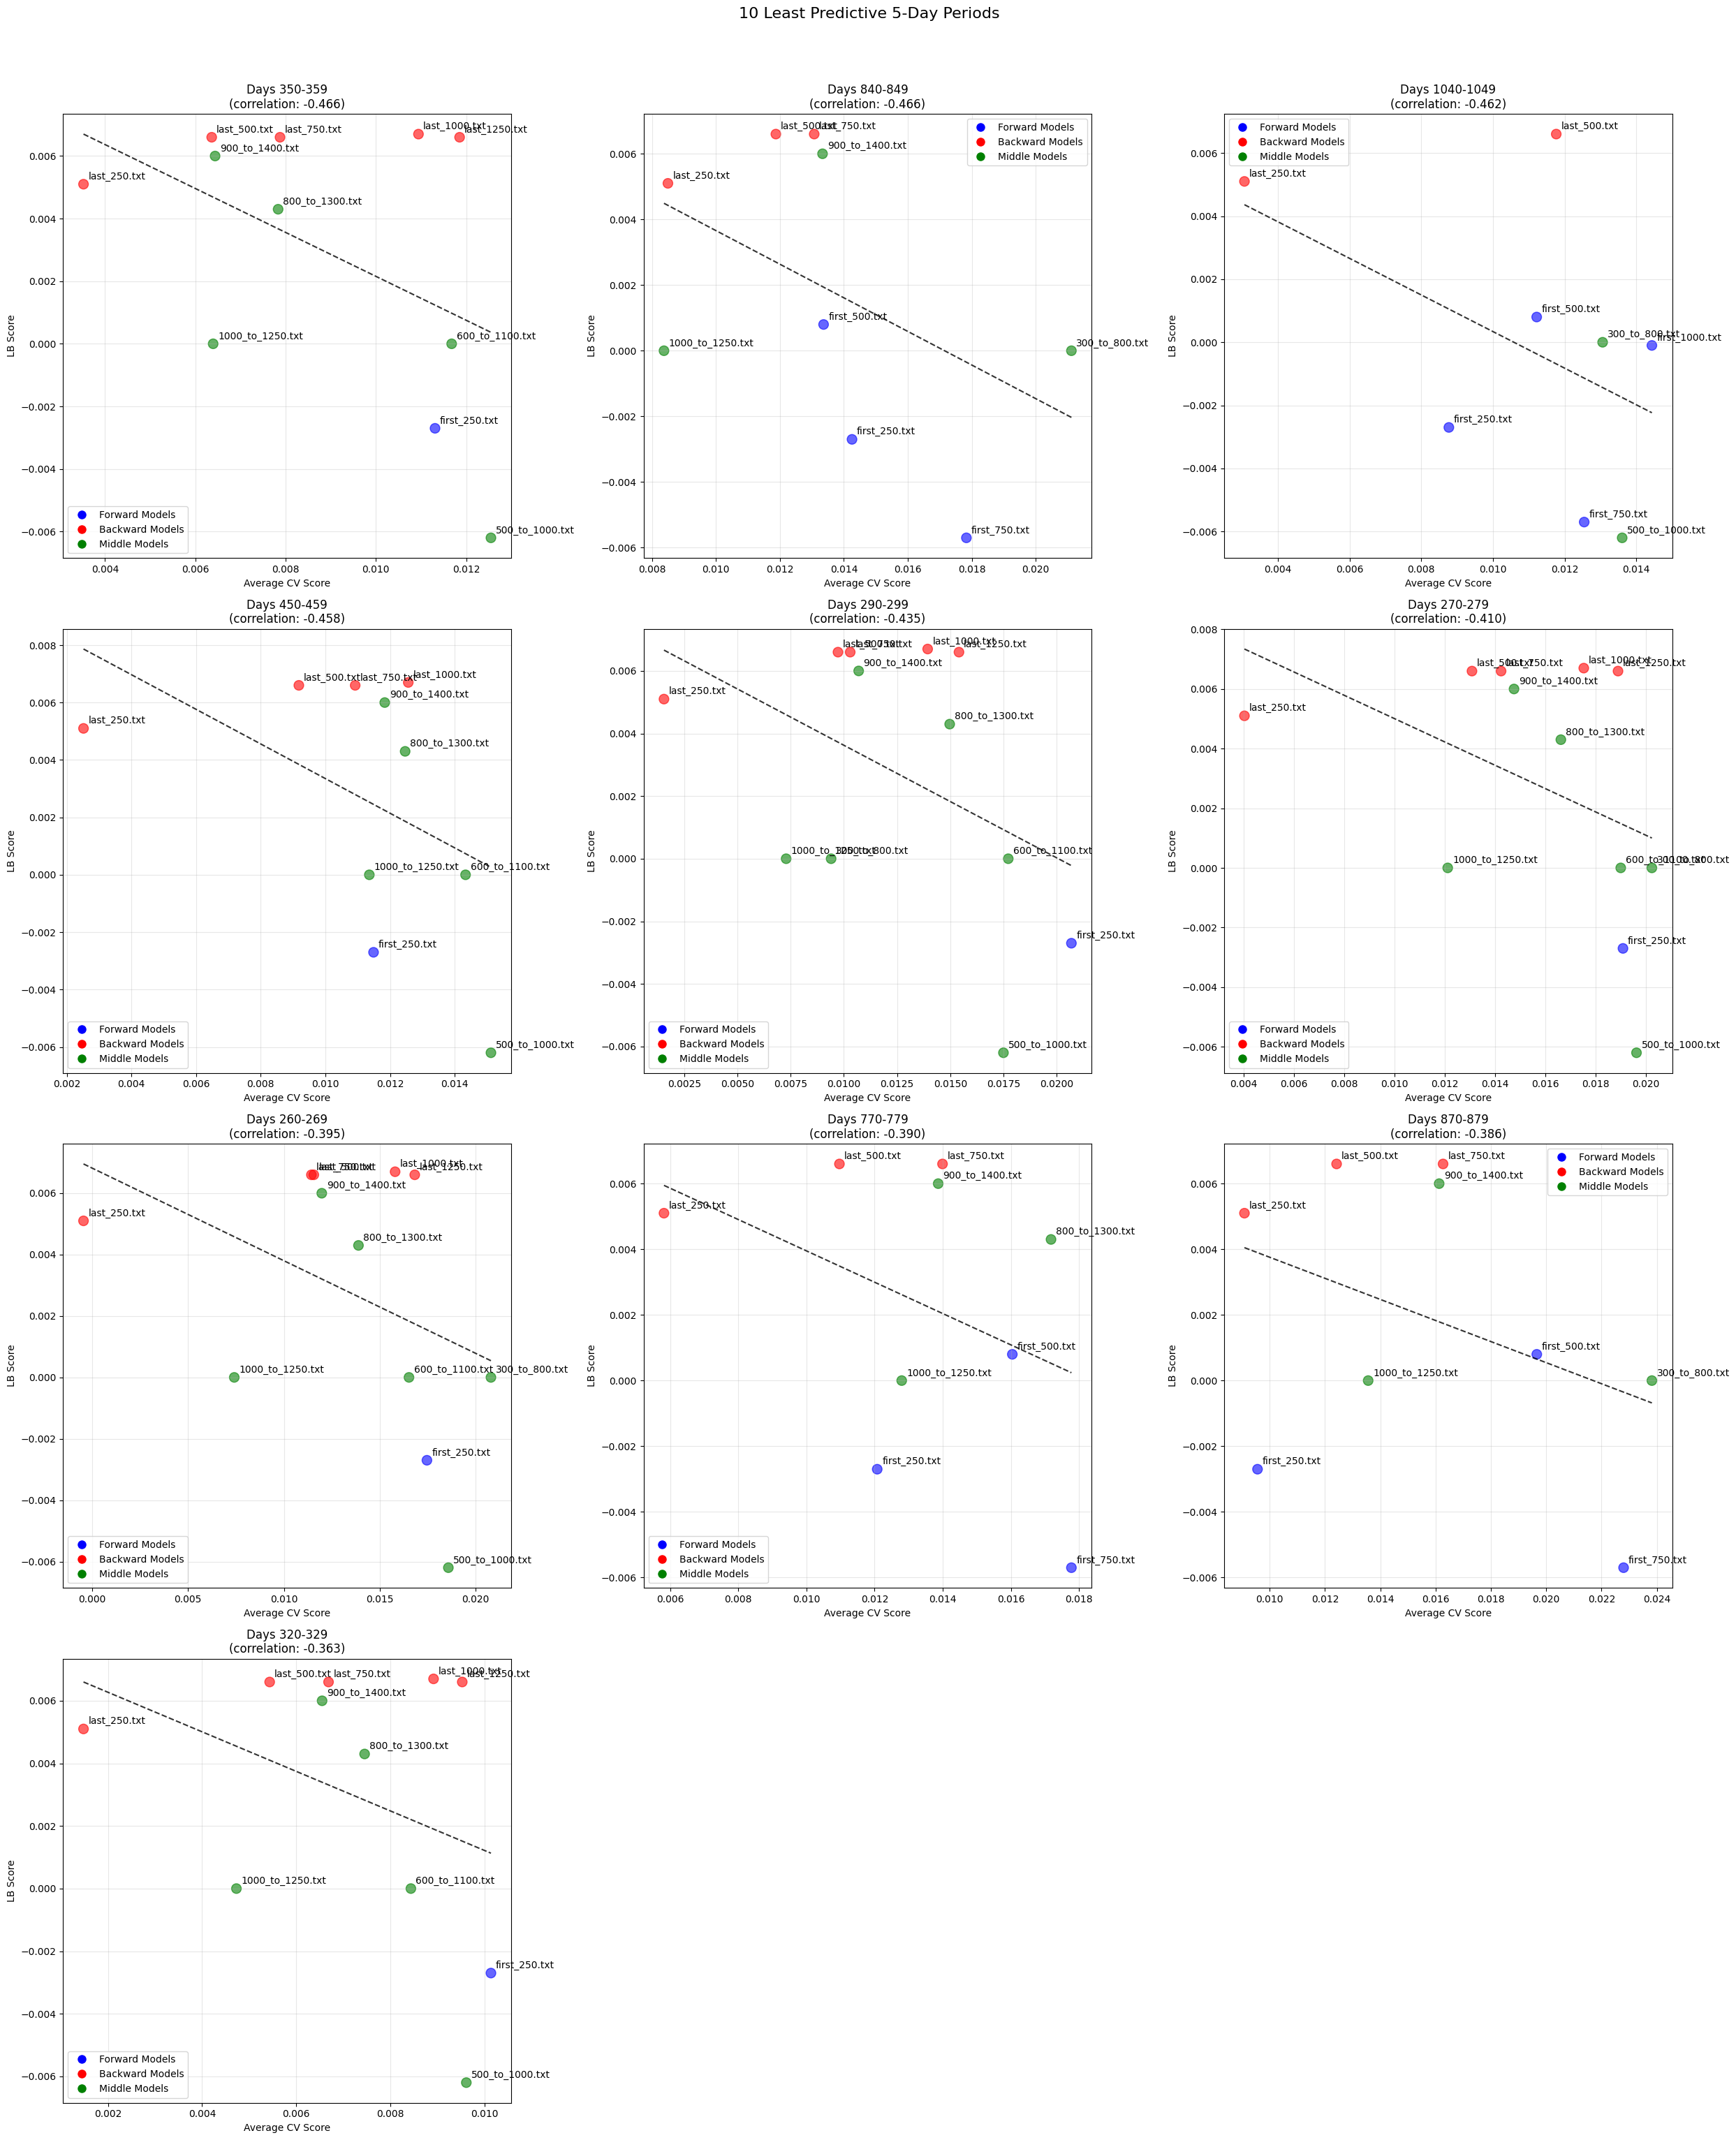


Total qualifying 5-day periods: 170
Average correlation: 0.080
Correlation std dev: 0.343

Top 10 most predictive periods:
--------------------------------------------------------------------------------

Days 1540-1549 (correlation: 0.863):
         1000_to_1250.txt CV:  0.0052    LB:  0.0000   
         300_to_800.txt  CV: -0.0083    LB:  0.0000   
         500_to_1000.txt CV: -0.0103    LB: -0.0062   
         600_to_1100.txt CV:  0.0084    LB:  0.0000   
         800_to_1300.txt CV:  0.0081    LB:  0.0043   
         900_to_1400.txt CV:  0.0102    LB:  0.0060   
         first_1000.txt  CV:  0.0023    LB: -0.0001   
         first_1250.txt  CV:  0.0045    LB:  0.0022   
         first_1500.txt  CV:  0.0095    LB:  0.0061   
         first_250.txt   CV: -0.0063    LB: -0.0027   
         first_500.txt   CV:  0.0016    LB:  0.0008   
         first_750.txt   CV: -0.0185    LB: -0.0057   

Days 1570-1579 (correlation: 0.859):
         1000_to_1250.txt CV:  0.0057    LB:  0.0000   
  

: 

In [ ]:
# Calculate correlation for each 5-day bin
bin_correlations = {}
bin_predictions = {}  
bin_size = 10

# Get min and max days
min_day = min(results_df['start_day'])
max_day = max(results_df['start_day'])

# Create bins
bins = list(range(min_day, max_day + bin_size, bin_size))

# Process each bin
for bin_start in bins:
    bin_end = bin_start + bin_size - 1
    day_scores = []
    lb_scores = []
    model_predictions = {}
    
    # Get all models' predictions for days in this bin
    for model_config in MODELS:
        model_name = model_config['name']
        train_start = model_config['train_start']
        train_end = model_config['train_end']
        r2_col = f'r2_score_{model_name}'
        
        # Get average score for this bin (outside training period)
        bin_mask = (results_df['start_day'] >= bin_start) & \
                  (results_df['start_day'] <= bin_end) & \
                  ((results_df['start_day'] < train_start) | \
                   (results_df['start_day'] > train_end))
        
        bin_scores = results_df[bin_mask][r2_col].dropna()
        
        if len(bin_scores) > 0:
            avg_score = bin_scores.mean()
            day_scores.append(avg_score)
            lb_scores.append(LB_SCORES[model_name])
            model_predictions[model_name] = (avg_score, LB_SCORES[model_name])
    
    # Calculate correlation if we have enough models
    if len(day_scores) >= 7:
        correlation = np.corrcoef(day_scores, lb_scores)[0,1]
        bin_correlations[bin_start] = correlation
        bin_predictions[bin_start] = model_predictions
    
# Get best and worst bins by correlation
top_bins = sorted(bin_correlations.items(), key=lambda x: x[1], reverse=True)[:10]
bottom_bins = sorted(bin_correlations.items(), key=lambda x: x[1])[:10]

# Function to create scatter plot for a bin
def plot_bin_correlation(ax, bin_start, correlation, predictions):
    day_scores = []
    lb_scores = []
    labels = []
    colors = []
    
    # Sort and prepare data
    sorted_predictions = sorted(predictions.items())
    for model_name, (day_score, lb_score) in sorted_predictions:
        day_scores.append(day_score)
        lb_scores.append(lb_score)
        labels.append(model_name)
        if model_name.startswith('first'):
            colors.append('blue')
        elif model_name.startswith('last'):
            colors.append('red')
        else:
            colors.append('green')
    
    # Create scatter plot
    scatter = ax.scatter(day_scores, lb_scores, c=colors, alpha=0.6, s=100)
    
    # Add trend line
    z = np.polyfit(day_scores, lb_scores, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(day_scores), max(day_scores), 100)
    ax.plot(x_range, p(x_range), "--", color='black', alpha=0.8, 
            label=f'Trend: y = {z[0]:.4f}x + {z[1]:.4f}')
    
    # Add labels
    for i, label in enumerate(labels):
        ax.annotate(label, (day_scores[i], lb_scores[i]), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10)
    
    # Customize plot
    ax.set_title(f'Days {bin_start}-{bin_start+bin_size-1}\n(correlation: {correlation:.3f})', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Average CV Score', fontsize=10)
    ax.set_ylabel('LB Score', fontsize=10)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  label='Forward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  label='Backward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  label='Middle Models', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)

# Create subplot figures
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('Top 10 Most Predictive 5-Day Periods', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (bin_start, correlation) in enumerate(top_bins):
    plot_bin_correlation(axes[idx], bin_start, correlation, bin_predictions[bin_start])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Create subplot figure for worst bins
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('10 Least Predictive 5-Day Periods', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (bin_start, correlation) in enumerate(bottom_bins):
    plot_bin_correlation(axes[idx], bin_start, correlation, bin_predictions[bin_start])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nTotal qualifying 5-day periods: {len(bin_correlations)}")
print(f"Average correlation: {np.mean(list(bin_correlations.values())):.3f}")
print(f"Correlation std dev: {np.std(list(bin_correlations.values())):.3f}")

# Print top and bottom bins
for title, bins_list in [("Top 10 most predictive periods:", top_bins), 
                        ("Bottom 10 least predictive periods:", bottom_bins)]:
    print(f"\n{title}")
    print("-" * 80)
    for bin_start, correlation in bins_list:
        print(f"\nDays {bin_start}-{bin_start+bin_size-1} (correlation: {correlation:.3f}):")
        predictions = bin_predictions[bin_start]
        for model_name, (day_score, lb_score) in sorted(predictions.items()):
            print(f"{'':<8} {model_name:<15} CV: {day_score:< 10.4f} LB: {lb_score:< 10.4f}")

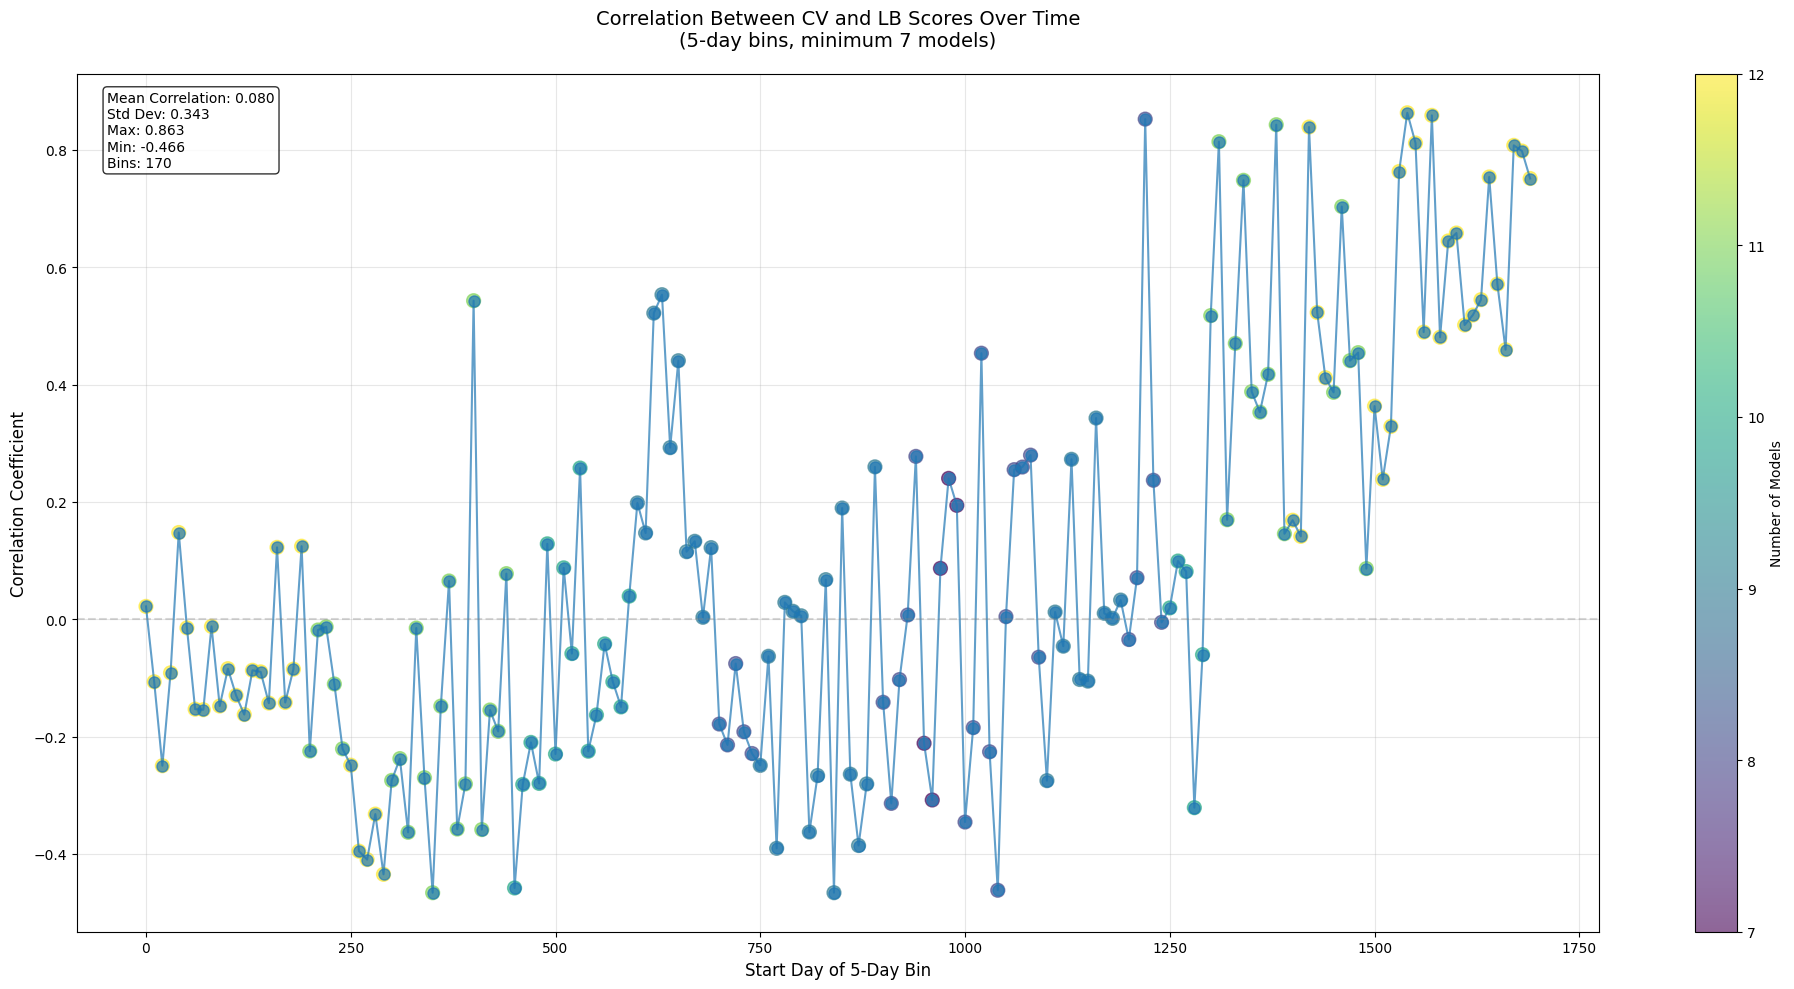

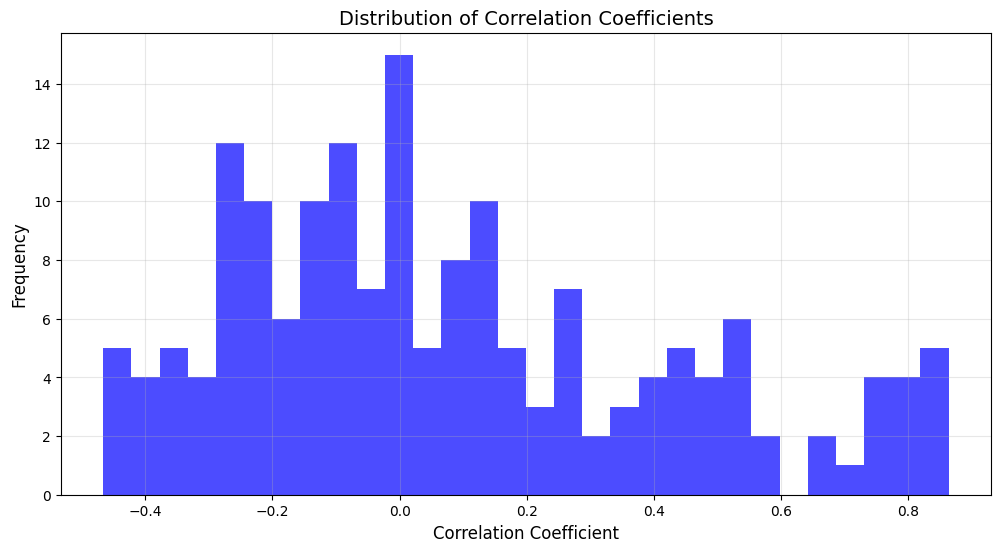


Correlation Statistics:
----------------------------------------
Number of bins: 170
Mean correlation: 0.080
Median correlation: 0.007
Std deviation: 0.343
Max correlation: 0.863
Min correlation: -0.466

Model Count Statistics:
----------------------------------------
Mean models per bin: 10.2
Max models per bin: 12
Min models per bin: 7


: 

In [ ]:
# Create figure for correlation over time
plt.figure(figsize=(20, 10))

# Get correlation data
bin_starts = list(bin_correlations.keys())
correlations = list(bin_correlations.values())
model_counts = [len(bin_predictions[bin_start]) for bin_start in bin_starts]

# Create main correlation plot
plt.plot(bin_starts, correlations, '-o', markersize=8, alpha=0.7, label='Correlation')

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Color the points based on number of models
scatter = plt.scatter(bin_starts, correlations, c=model_counts, cmap='viridis', 
                     s=100, alpha=0.6)
plt.colorbar(scatter, label='Number of Models')

# Customize plot
plt.title('Correlation Between CV and LB Scores Over Time\n(5-day bins, minimum 7 models)', 
          fontsize=14, pad=20)
plt.xlabel('Start Day of 5-Day Bin', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
stats_text = (f'Mean Correlation: {np.mean(correlations):.3f}\n'
             f'Std Dev: {np.std(correlations):.3f}\n'
             f'Max: {max(correlations):.3f}\n'
             f'Min: {min(correlations):.3f}\n'
             f'Bins: {len(correlations)}')
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Create histogram of correlations
plt.figure(figsize=(12, 6))
plt.hist(correlations, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Correlation Coefficients', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nCorrelation Statistics:")
print("-" * 40)
print(f"Number of bins: {len(correlations)}")
print(f"Mean correlation: {np.mean(correlations):.3f}")
print(f"Median correlation: {np.median(correlations):.3f}")
print(f"Std deviation: {np.std(correlations):.3f}")
print(f"Max correlation: {max(correlations):.3f}")
print(f"Min correlation: {min(correlations):.3f}")
print("\nModel Count Statistics:")
print("-" * 40)
print(f"Mean models per bin: {np.mean(model_counts):.1f}")
print(f"Max models per bin: {max(model_counts)}")
print(f"Min models per bin: {min(model_counts)}")

: 